# Import Libraries


In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

2025-05-10 20:37:46.379649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 20:37:46.388912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746884266.399239   26096 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746884266.402334   26096 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746884266.415420   26096 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load Essay Dataset

In [2]:
stdset = pd.read_excel("datasets/esai_siswa_24_25.xlsx")
gptset = pd.read_csv("datasets/esai_gpt_24_25.csv")

In [3]:
stdset.info()
stdset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   teks_esai     327 non-null    object
 1   nama          327 non-null    object
 2   asal_sekolah  327 non-null    object
 3   tahun         327 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.3+ KB


,teks_esai,nama,asal_sekolah,tahun
0,P3KTAS: Menciptakan Persatuan dalam Masyarakat...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
1,Apakah Anda memiliki teman atau saudara yang b...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
2,Dengan adanya perbedaan budaya tersebut banyak...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
3,Kasus diskriminasi terbesar di Indonesia lainn...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
4,Diskriminasi merupakan salah satu faktor yang ...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024


In [4]:
gptset.info()
gptset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Response  325 non-null    object
dtypes: object(1)
memory usage: 2.7+ KB


,Response
0,judul: merajut harmoni di tengah keberagaman: ...
1,keberagaman merupakan sebuah anugerah yang tid...
2,indonesia dikenal sebagai negeri dengan ribuan...
3,pendidikan multikultural harus menjadi bagian ...
4,"selain pendidikan formal, sosialisasi di komun..."


In [5]:
def preprocess_text(text):
    """
    Preprocessing text:
    - Convert text to lowercase
    - Cleaning up excess whitespace
    - Keeps the text as a whole paragraph
    
    Args:
        text (str): input text.
        
    Returns:
        str: the processed text or None if invalid.
    """
    if not isinstance(text, str) or text.strip() == "":
        return None
    
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('_x000d_', '')
    return text

# Essay Informations

In [6]:
# Count number of texts per author
author_counts = stdset.groupby('nama')['teks_esai'].count().sort_values(ascending=False)
author_alias = author_counts.index.map(lambda name: ' '.join([word[:2] + '*' * (len(word) - 2) for word in name.split()]))
author_names = author_counts.index
total_authors = len(author_counts)

# Count sentences in each text
def count_sentences(text):
    if not isinstance(text, str):
        return 0
    # Clean text first using existing preprocess_text function
    text = preprocess_text(text)
    if not text:
        return 0
    # Split by common sentence endings
    sentences = re.split('[.!?]+', text)
    # Remove empty strings
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

# Apply sentence counting to teks_esai
sentence_counts = stdset['teks_esai'].apply(count_sentences)

# Calculate statistics
single_sentence = sum(sentence_counts == 1)
multiple_sentences = sum(sentence_counts > 1)
total_texts = len(sentence_counts)

# Create a DataFrame to show statistics per author
author_stats = pd.DataFrame()
author_stats['nama'] = author_alias
author_stats['single_sentence'] = [sum(sentence_counts[stdset['nama'] == author] == 1) for author in author_names]
author_stats['multiple_sentences'] = [sum(sentence_counts[stdset['nama'] == author] > 1) for author in author_names]
author_stats['total_texts'] = author_counts.values

# Display the table
print("Statistics per Author:")
print(author_stats.to_string(index=False))

# Calculate and display summary statistics
print("\nStudent Summary:")
print(f"Total authors: {total_authors}")
print(f"Total texts: {total_texts}")
print(f"Total single sentences: {single_sentence}")
print(f"Total multiple sentences: {multiple_sentences}")
print(f"Minimum multiple sentences per author: {author_stats['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats['multiple_sentences'].max()}")
mean_multiple_sentences = author_stats['multiple_sentences'].mean()
print(f"Mean multiple sentences per author: {mean_multiple_sentences:.2f}")


Statistics per Author:
                                           nama  single_sentence  multiple_sentences  total_texts
                     Sy********* Mu****** Wa***                2                  28           30
                       Na**** Na****** La******                2                  18           20
                               Ar** Nu*********                5                  15           20
                        Na*** Iz**** Fi********                1                  19           20
                                De** Ty** Ut***                1                  18           19
                                   Le** Li*****                1                  18           19
                                 Sh***** Ta****                2                  15           17
                      Se*** An***** Wi*********                1                  16           17
                             Be*** Aq*** Ir****                1                  15           

In [7]:
# Create subsets based on year
author_stats_2024 = author_stats[author_names.isin(stdset[stdset['tahun'] == 2024]['nama'].unique())]
author_stats_2025 = author_stats[author_names.isin(stdset[stdset['tahun'] == 2025]['nama'].unique())]

# Print statistics for 2024
print("\nStatistics for 2024:")
print(f"Total authors: {len(author_stats_2024)}")
print(f"Total texts: {author_stats_2024['total_texts'].sum()}")
print(f"Total single sentences: {author_stats_2024['single_sentence'].sum()}")
print(f"Total multiple sentences: {author_stats_2024['multiple_sentences'].sum()}")
print(f"Minimum multiple sentences per author: {author_stats_2024['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats_2024['multiple_sentences'].max()}")
print(f"Mean multiple sentences per author: {author_stats_2024['multiple_sentences'].mean():.2f}")

# Print statistics for 2025  
print("\nStatistics for 2025:")
print(f"Total authors: {len(author_stats_2025)}")
print(f"Total texts: {author_stats_2025['total_texts'].sum()}")
print(f"Total single sentences: {author_stats_2025['single_sentence'].sum()}")
print(f"Total multiple sentences: {author_stats_2025['multiple_sentences'].sum()}")
print(f"Minimum multiple sentences per author: {author_stats_2025['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats_2025['multiple_sentences'].max()}")
print(f"Mean multiple sentences per author: {author_stats_2025['multiple_sentences'].mean():.2f}")



Statistics for 2024:
Total authors: 10
Total texts: 154
Total single sentences: 12
Total multiple sentences: 142
Minimum multiple sentences per author: 12
Maximum multiple sentences per author: 19
Mean multiple sentences per author: 14.20

Statistics for 2025:
Total authors: 10
Total texts: 173
Total single sentences: 17
Total multiple sentences: 156
Minimum multiple sentences per author: 10
Maximum multiple sentences per author: 28
Mean multiple sentences per author: 15.60


In [8]:
sentence_counts = gptset['Response'].apply(count_sentences)

# Calculate statistics
single_sentence = sum(sentence_counts == 1)
multiple_sentences = sum(sentence_counts > 1)
total_texts = len(sentence_counts)

print("\nChatGPT Summary:")
print(f"Total texts: {total_texts}")
print(f"Total single sentences: {single_sentence}")
print(f"Total multiple sentences: {multiple_sentences}")
print(f"Minimum multiple sentences per author: {author_stats['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats['multiple_sentences'].max()}")
mean_multiple_sentences = author_stats['multiple_sentences'].mean()
print(f"Mean multiple sentences per author: {mean_multiple_sentences:.2f}")


ChatGPT Summary:
Total texts: 325
Total single sentences: 20
Total multiple sentences: 305
Minimum multiple sentences per author: 10
Maximum multiple sentences per author: 28
Mean multiple sentences per author: 14.90


# Load Dataset for Training

In [9]:
#load dataset
std_txt = []
gpt_txt = []

# Process Student essay
for text in stdset['teks_esai']:
    if count_sentences(text) > 1:  
        processed = preprocess_text(text)
        if processed:
            std_txt.append(processed)

# Process ChatGPT essay
for text in gptset['Response']:
    if count_sentences(text) > 1:  
        processed = preprocess_text(text)
        if processed:
            gpt_txt.append(processed)

texts = std_txt + gpt_txt
labels = [0] * len(std_txt) + [1] * len(gpt_txt)
names = []
for idx, row in stdset.iterrows():
    if count_sentences(row['teks_esai']) > 1:
        censored_name = ' '.join([word[:2] + '*' * (len(word) - 2) for word in row['nama'].split()])
        names.append(censored_name)
    
names = names + ['ChatGPT'] * len(gpt_txt)
data = pd.DataFrame({'text': texts, 'label': labels, 'name': names})

# Show total number of processed texts
print(f"Total student text: {len(std_txt)}")
print(f"Total ChatGPT text: {len(gpt_txt)}")
print(f"Total texts: {len(texts)}")

print(data.head(5))
print(data.sample(5))


Total student text: 298
Total ChatGPT text: 305
Total texts: 603
                                                text  label  \
0  apakah anda memiliki teman atau saudara yang b...      0   
1  dengan adanya perbedaan budaya tersebut banyak...      0   
2  kasus diskriminasi terbesar di indonesia lainn...      0   
3  diskriminasi merupakan salah satu faktor yang ...      0   
4  pertama pendidikan, merupakan langkah awal dal...      0   

                   name  
0  Ac**** Mu****** Na**  
1  Ac**** Mu****** Na**  
2  Ac**** Mu****** Na**  
3  Ac**** Mu****** Na**  
4  Ac**** Mu****** Na**  
                                                  text  label  \
167  namun, sudahkah kita sepenuhnya memanfaatkan l...      0   
157  seperti petani yang sabar menunggu benih tumbu...      0   
546  melalui upaya untuk mengolah hidup, kita juga ...      1   
244  belum lagi jika membicarakan soal guru honorer...      0   
486  pendidikan dan pembelajaran seumur hidup adala...      1   

         

# Data Splitting
- Training 75%
- Validation 5%
- Testing 20%

In [10]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['label']
)

print(f"Initial training set: {len(train_data)} samples")
print(f"Initial test set: {len(test_data)} samples")
print(f"Initial training distribution: Student={sum(train_data['label']==0)}, ChatGPT={sum(train_data['label']==1)}")
print(f"Initial test distribution: Student={sum(test_data['label']==0)}, ChatGPT={sum(test_data['label']==1)}")


X_train = train_data[['text']]
y_train = train_data['label']

undersampler = RandomUnderSampler(random_state=42)
X_train_indices = pd.DataFrame({'index': range(len(X_train))})
X_resampled_indices, y_resampled = undersampler.fit_resample(X_train_indices, y_train)

selected_indices = X_resampled_indices['index'].values

balanced_train_data = train_data.iloc[selected_indices].reset_index(drop=True)

removed_indices = set(range(len(train_data))) - set(selected_indices)
removed_samples = train_data.iloc[list(removed_indices)]

test_set = pd.concat([test_data, removed_samples]).reset_index(drop=True)
test_set = test_set.sort_values(by='label').reset_index(drop=True)

train_set, val_set = train_test_split(
    balanced_train_data, test_size=5/80, random_state=42, stratify=balanced_train_data['label']
)

train_set = train_set.sort_values(by='label').reset_index(drop=True)
val_set = val_set.sort_values(by='label').reset_index(drop=True)

# Print final dataset statistics
print("\nAfter undersampling:")
print(f"Training set: {len(train_set)} samples (Student={sum(train_set['label']==0)}, ChatGPT={sum(train_set['label']==1)})")
print(f"Validation set: {len(val_set)} samples (Student={sum(val_set['label']==0)}, ChatGPT={sum(val_set['label']==1)})")
print(f"Test set: {len(test_set)} samples (Student={sum(test_set['label']==0)}, ChatGPT={sum(test_set['label']==1)})")


Initial training set: 482 samples
Initial test set: 121 samples
Initial training distribution: Student=238, ChatGPT=244
Initial test distribution: Student=60, ChatGPT=61

After undersampling:
Training set: 446 samples (Student=223, ChatGPT=223)
Validation set: 30 samples (Student=15, ChatGPT=15)
Test set: 127 samples (Student=60, ChatGPT=67)


# Initialize BERT Tokenizer

In [11]:
# Initialize IndoBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenize function
def tokenize_text(texts, max_length=256):
    """
    Text tokenization using IndoBERT tokenizer.
    
    Args:
        texts (list): List of texts to be tokenized.
        max_length (int): Maximum token length.
        
    Returns:
        dict: Tokenized result, including input_ids and attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [12]:
# Tokenize student and ChatGPT essays
print("Tokenize student essay...")
std_tokens = tokenize_text(std_txt)
print("Tokenize ChatGPT essay...")
gpt_tokens = tokenize_text(gpt_txt)

print("Tokenize student essay (Training Set)...")
std_tr_tokens = tokenize_text(train_set[train_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Training Set)...")
gpt_tr_tokens = tokenize_text(train_set[train_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Validation Set)...")
std_va_tokens = tokenize_text(val_set[val_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Validation Set)...")
gpt_va_tokens = tokenize_text(val_set[val_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Test Set)...")
std_te_tokens = tokenize_text(test_set[test_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Test Set)...")
gpt_te_tokens = tokenize_text(test_set[test_set['label'] == 1]['text'].tolist())

# Display tokenization results (example: Student)
print("\nExample of tokenization results:")
print(std_tr_tokens['input_ids'][:3])  # Input token ID
print(std_tr_tokens['attention_mask'][:3])  # Attention mask

Tokenize student essay...


I0000 00:00:1746884272.221361   26096 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Tokenize ChatGPT essay...
Tokenize student essay (Training Set)...
Tokenize ChatGPT essay (Training Set)...
Tokenize student essay (Validation Set)...
Tokenize ChatGPT essay (Validation Set)...
Tokenize student essay (Test Set)...
Tokenize ChatGPT essay (Test Set)...

Example of tokenization results:
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
tf.Tensor(
[[    2  6117 30468   387 14692    57    79  1429 30477  1946    34   234
   1858  1292    90  6566 30470   450  4107   126   699  2107  4813    41
   7058   436    26  2497  1343 30468 11253   219  2967   267  1947    90
   2638  2629   267   216  1229    79  3614  1429    34  1134    26  1182
    947 30470 10668   219  1632   997  3521   242  1429   256 30470   709
   3521 30468   232  1594   173  8208   436    90  6546  1313  1258    41
   1893  3343  5282 18381 30470   485 30468   751  1294  4156 12352 30468
    269   256   186   173  9026  2715  1258   436 30470    26  2123   245
  30468   960   186   173  

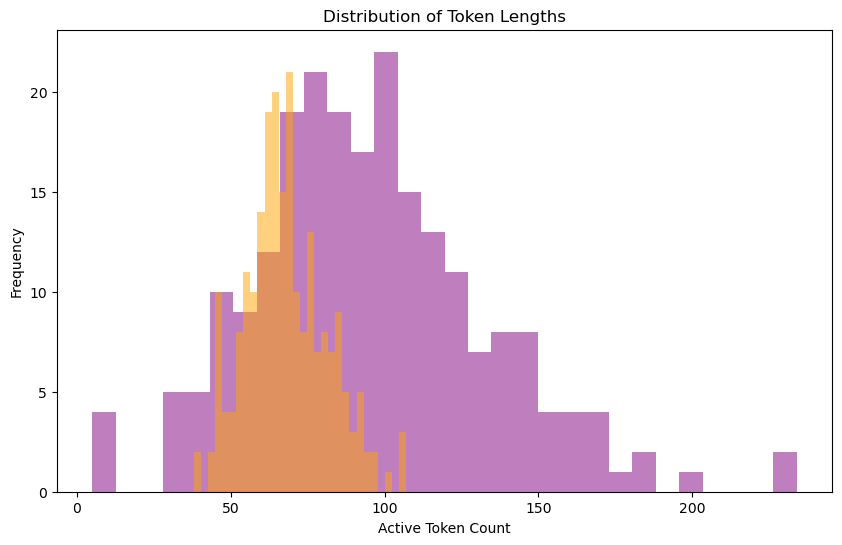

Average token length for Student: 95.32
Percentage truncated for Student: 0.00%
Average token length for ChatGPT: 68.04
Percentage truncated for ChatGPT: 0.00%


In [13]:
std_tr_lengths = [sum(mask) for mask in std_tr_tokens['attention_mask'].numpy()]
gpt_tr_lengths = [sum(mask) for mask in gpt_tr_tokens['attention_mask'].numpy()]

plt.figure(figsize=(10, 6))
plt.hist(std_tr_lengths, bins=30, alpha=0.5, label='Student', color='purple')
plt.hist(gpt_tr_lengths, bins=30, alpha=0.5, label='ChatGPT', color='orange')
plt.title('Distribution of Token Lengths')
plt.xlabel('Active Token Count')
plt.ylabel('Frequency')
plt.show()
print(f"Average token length for Student: {np.mean(std_tr_lengths):.2f}")
print(f"Percentage truncated for Student: {sum(l == 256 for l in std_tr_lengths) / len(std_tr_lengths) * 100:.2f}%")
print(f"Average token length for ChatGPT: {np.mean(gpt_tr_lengths):.2f}")
print(f"Percentage truncated for ChatGPT: {sum(l == 256 for l in gpt_tr_lengths) / len(gpt_tr_lengths) * 100:.2f}%")

In [14]:
# Decoding tokens for ensuring correctness
sample_text = gpt_txt[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Sample Text: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Sample Text: keberagaman merupakan sebuah anugerah yang tidak ternilai bagi bangsa indonesia. dalam setiap sudut negeri, kita dapat menemukan keunikan adat, budaya, bahasa, hingga kepercayaan yang berpadu dalam harmoni. masyarakat multikultural adalah cermin dari keragaman tersebut, yang jika dikelola dengan bijak dapat menjadi kekuatan besar dalam meraih kejayaan bersama. menerima keberagaman bukan berarti mengorbankan identitas, melainkan merangkul perbedaan sebagai bagian integral dari identitas bangsa.
Token ID: [2, 21585, 407, 492, 11766, 34, 119, 3881, 650, 396, 1642, 300, 30470, 112, 551, 4169, 1202, 30468, 219, 173, 1451, 10245, 4120, 30468, 1757, 30468, 744, 30468, 733, 4037, 34, 756, 3814, 112, 20596, 30470, 552, 30063, 154, 10564, 98, 14550, 256, 30468, 34, 338, 7635, 79, 7051, 173, 234, 2075, 421, 112, 3671, 16071, 943, 30470, 1644, 21585, 531, 1404, 15062, 5300, 30468, 3580, 22268, 2217, 242, 590, 17296, 98, 5300, 1642, 30470, 3]
Token dekode: [CLS] keberagaman merupakan s

In [15]:
# Save tokenized data
tokenized_data = {
    'student': std_tokens,
    'chatgpt': gpt_tokens
}

# Save input_ids and attention_mask as numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': std_tokens['input_ids'].numpy(),
        'attention_mask': std_tokens['attention_mask'].numpy()
    },
    'chatgpt ': {
        'input_ids': gpt_tokens ['input_ids'].numpy(),
        'attention_mask': gpt_tokens ['attention_mask'].numpy()
    }
}

os.makedirs("paper", exist_ok=True)

with open('paper/tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

# Build IndoBERT Semantic Similarity Model

In [16]:
# Load IndoBERT model
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Define Bi-Encoder model
def model(bert_model):
    """
    Create a Bi-Encoder model with IndoBERT.
    
    Args:
        bert_model (TFBertModel): Base model of IndoBERT.
        
    Returns:
        tf.keras.Model: Bi-Encoder model.
    """
    # Input layer
    input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings from IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer for fine-tuning
    dense1 = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(256)(dropout2)
    
    # Output normalization (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Semantic model
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Build model
semantic_model = model(bert_model)

# Show model summary
print("Model Summary:")
semantic_model.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                        

# Create Contrastive Pairs

In [17]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt = chatgpt_tokens['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt * (n_chatgpt - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt)
            negative_input_ids.append(chatgpt_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt) for j in range(i+1, n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor
            anchor_input_ids.append(chatgpt_tokens['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens['attention_mask'][idx1])
            
            # Positive
            positive_input_ids.append(chatgpt_tokens['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [18]:
# Create contrastive pairs
std_gpt_tr_pairs, total_pairs_tr = create_contrastive_pairs(std_tr_tokens, gpt_tr_tokens, max_pairs=None)
std_gpt_va_pairs, total_pairs_va = create_contrastive_pairs(std_va_tokens, gpt_va_tokens, max_pairs=None)

# Show the number of pairs created
print(f"Total contrastive pairs (training) created: {total_pairs_tr}")
print(f"- Positive pairs student-student: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Positive pairs chatgpt-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Negative pairs student-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 0)}")


Total contrastive pairs (training) created: 49504
- Positive pairs student-student: 12376
- Positive pairs chatgpt-chatgpt: 12376
- Negative pairs student-chatgpt: 24752


# Build Triplet Model

In [19]:
# Model for training with triplet loss
def triplet_model(semantic_model):
    """
    Build a model for training with triplet loss.
    
    Args:
        semantic_model: The semantic similarity model to be trained.
        
    Returns:
         tf.keras.Model: Model for training with triplet loss.
    """
    # Input for anchor, positive, and negative
    anchor_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_attention_mask")
    
    positive_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding for anchor, positive, and negative
    anchor_embedding = semantic_model([anchor_input_ids, anchor_attention_mask])
    positive_embedding = semantic_model([positive_input_ids, positive_attention_mask])
    negative_embedding = semantic_model([negative_input_ids, negative_attention_mask])
    
    # measure cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Model output is the similarity score
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

# Triplet Loss Function

In [20]:
# Triplet loss function
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: tunes the network such that
the distance between a and p is smaller than the
distance between a and n.
    
    Args:
        y_true: not used triplet loss.
        y_pred: stack of [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: loss value.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

# Train IndoBERT Semantic Similarity Model

In [21]:
# Build triplet model for student vs ChatGPT essay
build_triplet = triplet_model(semantic_model)

# Compile model
build_triplet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training model...")
history = build_triplet.fit(
    x=[
        std_gpt_tr_pairs['anchor']['input_ids'],
        std_gpt_tr_pairs['anchor']['attention_mask'],
        std_gpt_tr_pairs['positive']['input_ids'],
        std_gpt_tr_pairs['positive']['attention_mask'],
        std_gpt_tr_pairs['negative']['input_ids'],
        std_gpt_tr_pairs['negative']['attention_mask']
    ],
    y=std_gpt_tr_pairs['labels'], 
    epochs=10,
    batch_size=16,
    validation_data=(
    [
        std_gpt_va_pairs['anchor']['input_ids'],
        std_gpt_va_pairs['anchor']['attention_mask'],
        std_gpt_va_pairs['positive']['input_ids'],
        std_gpt_va_pairs['positive']['attention_mask'],
        std_gpt_va_pairs['negative']['input_ids'],
        std_gpt_va_pairs['negative']['attention_mask']
    ],
    std_gpt_va_pairs['labels']
    ),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training model...
Epoch 1/10


I0000 00:00:1746884320.767672   26241 service.cc:152] XLA service 0x7f7d0c131220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746884320.767708   26241 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-05-10 20:38:40.772227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746884320.782497   26241 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746884320.860500   26241 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3094/3094 [==============================] - 1467s 471ms/step - loss: 0.1392 - val_loss: 0.2089
Epoch 2/10
3094/3094 [==============================] - 1457s 471ms/step - loss: 0.0260 - val_loss: 0.1638
Epoch 3/10
3094/3094 [==============================] - 1468s 475ms/step - loss: 0.0101 - val_loss: 0.1705
Epoch 4/10
3094/3094 [==============================] - 1468s 474ms/step - loss: 0.0064 - val_loss: 0.2021


# Training History

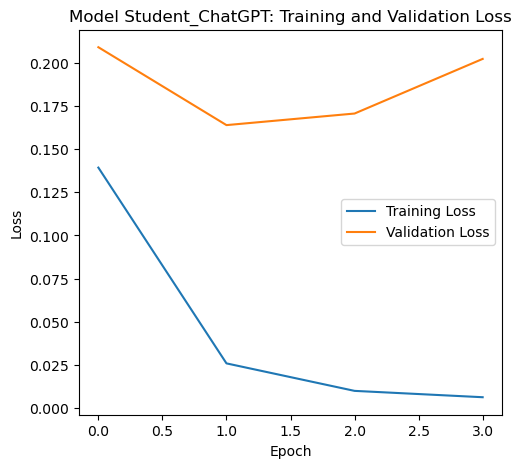

In [22]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate Embeddings Function

In [23]:
def gen_emb(tokens, model, batch_size=32):
    """
    Generate embeddings using IndoBERT in batches.
    
    Args:
        tokens: Token from text.
        model: IndoBERT Semantic Similarity.
        batch_size: Number of samples per batch.
        
    Returns:
        np.ndarray: Embeddings.
    """
    embeddings = []
    
    num_batches = len(tokens['input_ids']) // batch_size + (len(tokens['input_ids']) % batch_size > 0)
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(tokens['input_ids']))

        batch_input_ids = tokens['input_ids'][start_idx:end_idx]
        batch_attention_mask = tokens['attention_mask'][start_idx:end_idx]
        
        batch_embeddings = model([batch_input_ids, batch_attention_mask])
        
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Cosine Similarity Function

In [24]:
def cos_sim(embedding1, embedding2):
    """
    Calculate similarity score using standard cosine similarity.
    
    Args:
        embedding1: First embedding (input text)
        embedding2: Second embedding (reference)
        
    Returns:
        float: Average cosine similarity score
    """
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])

    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity


# Generate Embeddings (All Text)

In [25]:
# Generate embeddings for all text
print("Generating embeddings for Student (all text)...")
std_emb = gen_emb(std_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (all text)...")
gpt_emb = gen_emb(gpt_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (all text)...
Generating embeddings for ChatGPT (all text)...


# Measure Similarity Score (All Text)

In [26]:
std_std_sim_scores = []
std_gpt_sim_scores = []
for emb in std_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_sim_scores.append(avg_similarity)

gpt_std_sim_scores = []
gpt_gpt_sim_scores = []
for emb in gpt_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_sim_scores.append(avg_similarity)

std_sim_scores = np.array([
    std_std_sim_scores, 
    std_gpt_sim_scores
])

gpt_sim_scores = np.array([
    gpt_std_sim_scores, 
    gpt_gpt_sim_scores
])

# Visualization of Similarity Score (All Text)

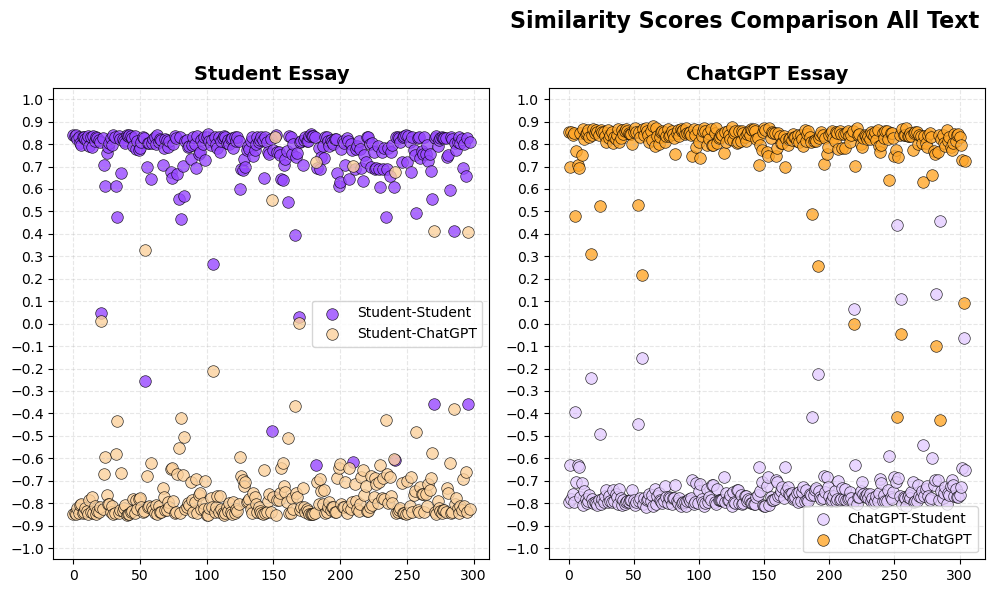

In [27]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_sim_scores)), std_std_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_sim_scores)), std_gpt_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_sim_scores)), gpt_std_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_sim_scores)), gpt_gpt_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison All Text', fontsize=16, fontweight='bold', y=0.98, ha='center')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

os.makedirs('paper/images', exist_ok=True)
plt.savefig('paper/images/similarity_scores_comparison(all).png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Test Set)

In [28]:
# Generate embeddings for data test
print("Generating embeddings for Student (test set)...")
std_te_emb = gen_emb(std_te_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (test set)...")
gpt_te_emb = gen_emb(gpt_te_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (test set)...
Generating embeddings for ChatGPT (test set)...


# Measure Similarity Score (Test Set)

In [29]:
std_std_te_sim_scores = []
std_gpt_te_sim_scores = []
for emb in std_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_te_sim_scores.append(avg_similarity)

gpt_std_te_sim_scores = []
gpt_gpt_te_sim_scores = []
for emb in gpt_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_te_sim_scores.append(avg_similarity)

std_te_sim_scores = np.array([
    std_std_te_sim_scores, 
    std_gpt_te_sim_scores
])

gpt_te_sim_scores = np.array([
    gpt_std_te_sim_scores, 
    gpt_gpt_te_sim_scores
])

# Similarity Text Breakdown (Test Set)

In [30]:
test_pairs = []
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_rows', None)      

for i, student_text in enumerate(std_txt):
    if i >= len(std_te_emb):
        continue
        
    student_embedding = tf.expand_dims(std_te_emb[i], 0)

    for j in range(len(gpt_txt)):
        if j >= len(gpt_te_emb):
            continue

        chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
        similarity = cos_sim(student_embedding, chatgpt_embedding)
        
        test_pairs.append({
            'student_idx': i,
            'chatgpt_idx': j,
            'student_text': student_text,
            'chatgpt_text': gpt_txt[j],
            'similarity_score': similarity
        })

sorted_pairs = sorted(test_pairs, key=lambda x: x['similarity_score'], reverse=True)

result_v1 = sorted_pairs[:5]

df_v1 = pd.DataFrame(result_v1)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v1.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 1: Standard ===")
display(df_v1)

used_student_indices_v2 = set()
used_chatgpt_indices_v2 = set()
result_v2 = []

for pair in sorted_pairs:
    if (pair['student_idx'] in used_student_indices_v2 or 
        pair['chatgpt_idx'] in used_chatgpt_indices_v2):
        continue
    result_v2.append(pair)
    used_student_indices_v2.add(pair['student_idx'])
    used_chatgpt_indices_v2.add(pair['chatgpt_idx'])
    if len(result_v2) >= 5:
        break

df_v2 = pd.DataFrame(result_v2)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v2.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 2: Unique ===")
display(df_v2)

=== 1: Standard ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"gen z turut mendukung adanya kesetaraan bagi setiap individu. salah satu gerakan yang dikampanyekan oleh gen z adalah menggeser standar kecantikan sosial yang selama ini berlaku di masyarakat. suara yang digaungkan oleh gen z yaitu bahwa kecantikan seseorang tidak mengacu pada warna kulit, tinggi badan, berat badan, hingga ras tertentu. hal ini yang kemudian mendorong masyarakat khususnya generasi muda semakin percaya diri dan bebas dalam menggunakan media sosial sebagai sarana berekspresi.","dalam upaya mewujudkan kejayaan dalam masyarakat multikultural, seluruh elemen bangsa harus berkomitmen untuk menjaga persatuan dan kesatuan. komitmen ini harus diwujudkan dalam aksi nyata dan kebijakan yang berkelanjutan. peran aktif seluruh lapisan masyarakat, baik pemerintah, swasta, maupun individu, sangat diperlukan untuk menciptakan tatanan sosial yang damai dan harmonis.",0.933612
1,"gen z turut mendukung adanya kesetaraan bagi setiap individu. salah satu gerakan yang dikampanyekan oleh gen z adalah menggeser standar kecantikan sosial yang selama ini berlaku di masyarakat. suara yang digaungkan oleh gen z yaitu bahwa kecantikan seseorang tidak mengacu pada warna kulit, tinggi badan, berat badan, hingga ras tertentu. hal ini yang kemudian mendorong masyarakat khususnya generasi muda semakin percaya diri dan bebas dalam menggunakan media sosial sebagai sarana berekspresi.","keberagaman bukanlah ancaman, melainkan kekuatan yang harus dikelola dengan baik. dalam konteks globalisasi, masyarakat yang bisa merangkul keberagaman akan lebih kompetitif dan adaptif dalam menghadapi tantangan di panggung dunia. penghargaan terhadap keragaman menjadi salah satu nilai yang sangat dihargai dalam kerjasama internasional. oleh karena itu, bangsa indonesia harus bangga dan terus memelihara keberagaman yang dimiliki.",0.928150
2,"gen z turut mendukung adanya kesetaraan bagi setiap individu. salah satu gerakan yang dikampanyekan oleh gen z adalah menggeser standar kecantikan sosial yang selama ini berlaku di masyarakat. suara yang digaungkan oleh gen z yaitu bahwa kecantikan seseorang tidak mengacu pada warna kulit, tinggi badan, berat badan, hingga ras tertentu. hal ini yang kemudian mendorong masyarakat khususnya generasi muda semakin percaya diri dan bebas dalam menggunakan media sosial sebagai sarana berekspresi.","meski demikian, tantangan dalam merawat keberagaman tetap ada. diskriminasi dan prasangka masih sering terjadi dan menjadi hambatan dalam menciptakan masyarakat yang harmonis. oleh karena itu, perlu adanya upaya terus-menerus dalam mengedukasi dan membangun kesadaran masyarakat terhadap pentingnya keberagaman. kesadaran kolektif adalah kunci dalam membangun masyarakat yang lebih adil dan setara.",0.921248
3,"gen z turut mendukung adanya kesetaraan bagi setiap individu. salah satu gerakan yang dikampanyekan oleh gen z adalah menggeser standar kecantikan sosial yang selama ini berlaku di masyarakat. suara yang digaungkan oleh gen z yaitu bahwa kecantikan seseorang tidak mengacu pada warna kulit, tinggi badan, berat badan, hingga ras tertentu. hal ini yang kemudian mendorong masyarakat khususnya generasi muda semakin percaya diri dan bebas dalam menggunakan media sosial sebagai sarana berekspresi.","generasi muda memegang peran krusial sebagai agen perubahan dalam masyarakat multikultural. mereka adalah pelopor yang membawa semangat toleransi dan kebersamaan dalam setiap komunitas yang mereka ikuti. dengan dukungan dan bimbingan yang tepat, generasi muda dapat menciptakan lingkungan yang harmonis dan penuh kedamaian. partisipasi aktif mereka dalam berbagai kegiatan sosial dan kebangsaan akan menjadi motor penggerak utama dalam mencapai kejayaan bangsa.",0.919354
4,"gen z turut mendukung adanya kesetaraan bagi setiap individu. salah satu gerakan yang dikampanyekan oleh gen z adalah menggeser standar kecantikan sosial yang selama ini berlaku di masyarakat. suara yang digaungkan oleh gen z yait

=== 2: Unique ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"gen z turut mendukung adanya kesetaraan bagi setiap individu. salah satu gerakan yang dikampanyekan oleh gen z adalah menggeser standar kecantikan sosial yang selama ini berlaku di masyarakat. suara yang digaungkan oleh gen z yaitu bahwa kecantikan seseorang tidak mengacu pada warna kulit, tinggi badan, berat badan, hingga ras tertentu. hal ini yang kemudian mendorong masyarakat khususnya generasi muda semakin percaya diri dan bebas dalam menggunakan media sosial sebagai sarana berekspresi.","dalam upaya mewujudkan kejayaan dalam masyarakat multikultural, seluruh elemen bangsa harus berkomitmen untuk menjaga persatuan dan kesatuan. komitmen ini harus diwujudkan dalam aksi nyata dan kebijakan yang berkelanjutan. peran aktif seluruh lapisan masyarakat, baik pemerintah, swasta, maupun individu, sangat diperlukan untuk menciptakan tatanan sosial yang damai dan harmonis.",0.933612
1,"sebagai bahan penutup, mari kita ingat kutipan dari bapak proklamator kita, presiden soekarno. “negeri ini, republik indonesia, bukanlah milik suatu golongan, bukan milik suatu agama, bukan milik suatu kelompok etnis, bukan juga milik suatu adat-istiadat tertentu, tapi milik kita semua dari sabang sampai merauke!” ini adalah pesan dari presiden soekarno untuk kita semua. pesan ini harus selalu diingat oleh setiap warga negara indonesia, pesan yang mendorong kita untuk bersatu. dengan mengingat pesan ini, kita harus berdiri bersama sebagai satu bangsa, satu suara, untuk melindungi dan memajukan negeri ini. karena kita semua adalah pemilik dari negara kesatuan republik indonesia, dari sabang sampai merauke. mari kita jaga, cintai, dan banggakan tanah air kita. indonesia, negeri kita, rumah kita. merdeka!","namun, harmonisasi keberagaman ini tidak terbentuk begitu saja. diperlukan upaya sadar dari setiap individu untuk membangun komunikasi yang efektif. dialog terbuka menjadi kunci untuk menangani segala bentuk kesalahpahaman yang mungkin timbul. diskusi yang sehat memungkinan kita untuk menggali dan memahami alasan di balik perbedaan, memperkuat pondasi persatuan.",0.777601
2,"keragaman budaya adalah anugerah yang ada di bumi indonesia. keragaman budaya di indonesia adalah sesuatu yang tidak dapat dipungkiri keberadaannya. jika kita merujuk kepada konvensi unesco 2005 tentang keragaman budaya atau “cultural diversity”, cultural diversity diartikan sebagai kekayaan budaya yang dilihat sebagai cara yang ada dalam kebudayaan kelompok atau masyarakat untuk mengungkapkan ekspresinya. hal ini tidak hanya berkaitan dalam keragaman budaya yang menjadi kebudayaan latar belakangnya, namun juga variasi cara dalam penciptaan artistik, produksi, disseminasi, distribusi dan penghayatannya, apapun makna dan teknologi yang digunakannya. atau diistilahkan oleh unesco dalam dokumen konvensi unesco 2005 sebagai “ekpresi budaya” (cultural expression). isi dari keragaman budaya tersebut akan mengacu kepada makna simbolik, dimensi artistik, dan nilai-nilai budaya yang melatarbelakanginya.","namun, teknologi juga memiliki sisi gelap ketika disalahgunakan. penyebaran hoaks dan ujaran kebencian adalah ancaman nyata yang bisa merusak integritas sosial. karenanya, literasi digital menjadi kebutuhan mendesak agar masyarakat mampu memilah dan memahami informasi dengan kritis.",0.649204
3,"masyarakat indonesia yang menjadi pengguna aktif internet cukup beragam dan terdiri dari beberapa generasi seperti baby boomers, generasi x, generasi milenial, generasi z, dan generasi alpha. meskipun demikian, generasi z menjadi generasi dengan tingkat penggunaan internet tertinggi. hal ini disebabkan rentang usia generasi z relatif muda dan mendapat paparan teknologi internet yang lebih intens dibandingkan generasi-generasi sebelumnya.","maka, mari kita tantang diri untuk terus mengedepankan toleransi, empati, dan saling menghargai di tengah pluralitas yang ada. dengan demikian, kita tidak hanya merayakan kebanggaan akan keberagaman kita, tetapi ju

# Visualization of Similarity Score (Test Set)

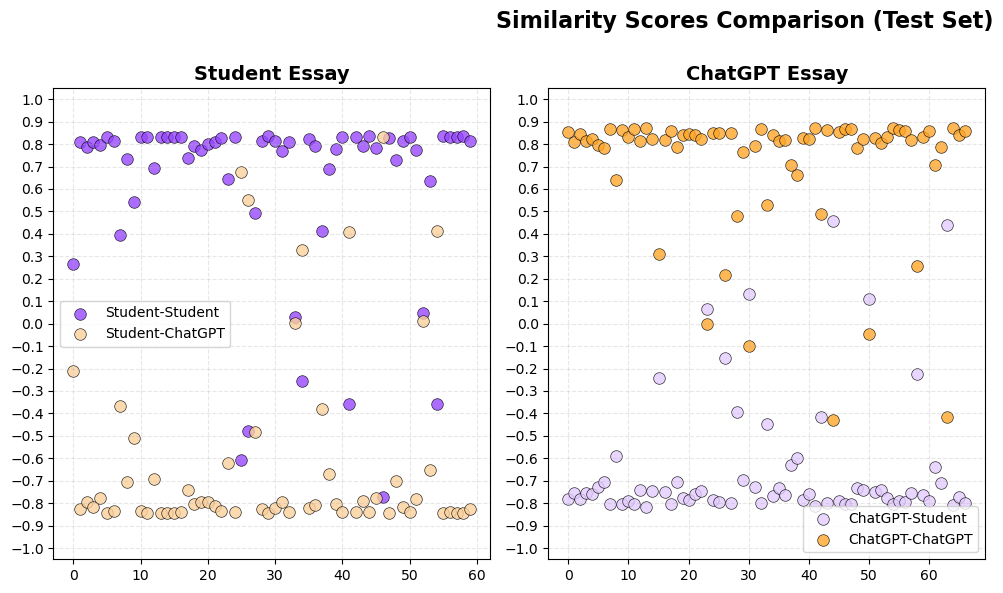

In [31]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_te_sim_scores)), std_std_te_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_te_sim_scores)), std_gpt_te_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_te_sim_scores)), gpt_std_te_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_te_sim_scores)), gpt_gpt_te_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison (Test Set)', fontsize=16, fontweight='bold', y=0.98, ha='center')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

plt.savefig('paper/images/similarity_scores_comparison(test).png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Training & Validation Sets)

In [32]:
# Generate embeddings for training and validation sets
print("Generating embeddings for Student (training set)...")
std_tr_emb = gen_emb(std_tr_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (training set)...")
gpt_tr_emb = gen_emb(gpt_tr_tokens, semantic_model, batch_size=32)

print("Generating embeddings for Student (validation set)...")
std_va_emb = gen_emb(std_va_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (validation set)...")
gpt_va_emb = gen_emb(gpt_va_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (training set)...
Generating embeddings for ChatGPT (training set)...
Generating embeddings for Student (validation set)...
Generating embeddings for ChatGPT (validation set)...


# Measure Similarity Score (Training & Validation Sets)

In [33]:
# Training set
std_std_tr_sim_scores = []
std_gpt_tr_sim_scores = []
for emb in std_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_tr_sim_scores.append(avg_similarity)

gpt_std_tr_sim_scores = []
gpt_gpt_tr_sim_scores = []
for emb in gpt_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_tr_sim_scores.append(avg_similarity)

std_tr_sim_scores = np.array([
    std_std_tr_sim_scores, 
    std_gpt_tr_sim_scores
])

gpt_tr_sim_scores = np.array([
    gpt_std_tr_sim_scores, 
    gpt_gpt_tr_sim_scores
])

# Validation set
std_std_va_sim_scores = []
std_gpt_va_sim_scores = []
for emb in std_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_va_sim_scores.append(avg_similarity)

gpt_std_va_sim_scores = []
gpt_gpt_va_sim_scores = []
for emb in gpt_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_va_sim_scores.append(avg_similarity)

std_va_sim_scores = np.array([
    std_std_va_sim_scores, 
    std_gpt_va_sim_scores
])

gpt_va_sim_scores = np.array([
    gpt_std_va_sim_scores, 
    gpt_gpt_va_sim_scores
])

# Define Linguistic Features

In [34]:
def linguistic_features(text):
    """
    Features extraction from text:
    1.	Lexical Diversity
    2.	Total words in the essay
    3.	Total unique words*
    4.	Modals
    5.	Stopwords ratio*
    6.	Average sentence length*
    7.	Sentence length variation*
    8.	Punctuation Ratio*

    
    Args:
        text (str): Input text.
        
    Returns:
        dict: Linguistic features.
    """
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    word_count = len(words)
    unique_count = len(set(words))
    
    ld = (unique_count / word_count * 100) if word_count > 0 else 0
    
    # Load modals from corpus file
    modals = set()
    if os.path.exists('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv'):
        with open('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv', 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split('\t')
                    if len(parts) >= 2 and parts[1] == 'MD':
                        modals.add(parts[0].lower())
    
    # Count modals in text
    modal_count = sum(1 for word in words if word.lower() in modals)
    
    # Load stopwords from file
    stopwords = set()
    if os.path.exists('corpus/stopwords.txt'):
        with open('corpus/stopwords.txt', 'r', encoding='utf-8') as f:
            for line in f:
                stopwords.add(line.strip())
    
    # Calculate stopword ratio
    stopword_count = sum(1 for word in words if word.lower() in stopwords)
    stopword_ratio = (stopword_count / word_count * 100) if word_count > 0 else 0
    
    # Calculate sentence length statistics
    sentence_lengths = [len(re.findall(r'\b\w+\b', s)) for s in sentences]
    avg_sent_len = np.mean(sentence_lengths) if sentence_lengths else 0
    sent_len_var = np.std(sentence_lengths) if len(sentence_lengths) > 1 else 0
    
    # Calculate punctuation ratio
    punct_count = len(re.findall(r'[.!?]', text))
    punct_ratio = (punct_count / word_count) * 100 if word_count > 0 else 0

    return {
        'lexical_diversity': ld,
        'total_words': word_count,
        'total_unique_words': unique_count,
        'modals': modal_count,
        'stopwords_ratio': stopword_ratio,
        'avg_sentence_length': avg_sent_len,
        'sentence_length_variation': sent_len_var,
        'punctuation_ratio': punct_ratio
    }

# Features Extraction (All Text)

In [35]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student...")
std_features = [linguistic_features(text) for text in std_txt]

print("Features extraction for ChatGPT...")
gpt_features = [linguistic_features(text) for text in gpt_txt]


# convert
std_features_df = pd.DataFrame(std_features)
gpt_features_df = pd.DataFrame(gpt_features)


# Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features:")
display(std_features_df.head())

print("\nChatGPT Linguistic Features:")
display(gpt_features_df.head())

Features extraction for Student...
Features extraction for ChatGPT...

Student Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,61.111111,108,66,1,45.370370,12.000000,6.582806,9.259259
1,72.881356,118,86,2,37.288136,8.428571,6.935563,11.864407
2,82.653061,98,81,0,36.734694,10.888889,7.030796,9.183673
3,71.929825,57,41,0,36.842105,19.000000,9.933110,5.263158
4,76.190476,42,32,1,54.761905,14.000000,2.449490,7.142857



ChatGPT Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,85.483871,62,53,2,46.774194,15.50,3.640055,6.451613
1,84.507042,71,60,2,40.845070,14.20,3.919184,7.042254
2,86.792453,53,46,3,49.056604,13.25,2.861381,7.547170
3,81.355932,59,48,3,42.372881,14.75,2.165064,6.779661
4,80.000000,60,48,3,43.333333,15.00,2.121320,6.666667


# Normalize Linguistic Features (All Text)

In [36]:
# Combine features into a single DataFrame
all_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Separate normalized features back into student and ChatGPT
n_student = len(std_features_df)
n_chatgpt = len(gpt_features_df)

std_features_norm = normalized_features[:n_student]
gpt_features_norm = normalized_features[n_student:n_student + n_chatgpt]

print("Student features after normalization:")
print(std_features_norm[:5])

print("ChatGPT features after normalization:")
print(gpt_features_norm[:5])

# Save scaler for later inference
try:
    with open('paper/scaler_stylometric.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Scaler saved successfully.")
except Exception as e:
    print(f"Error saving scaler: {e}")

Student features after normalization:
[[-2.36686444  1.54914156  0.81188744 -0.66754096 -0.41540807 -1.09770194
   0.79265579  0.78970394]
 [-0.87891772  1.93193562  2.01653342 -0.10298668 -1.36576934 -2.00807336
   0.92983011  1.55808722]
 [ 0.35638172  1.16634749  1.71537192 -1.23209524 -1.43084659 -1.3809286
   0.96686267  0.76741006]
 [-0.99920646 -0.40310818 -0.69392004 -1.23209524 -1.41821646  0.68662605
   2.09546441 -0.38893851]
 [-0.46059212 -0.97729928 -1.23601073 -0.66754096  0.68890909 -0.58789394
  -0.81463727  0.16547519]]
ChatGPT features after normalization:
[[ 0.71424124 -0.21171115  0.02886755 -0.10298668 -0.25033749 -0.20553795
  -0.3516707  -0.03840598]
 [ 0.5907545   0.13280351  0.45049365 -0.10298668 -0.94752201 -0.53691314
  -0.24312795  0.13580234]
 [ 0.87966686 -0.55622581 -0.39275854  0.46156759  0.01804302 -0.77907194
  -0.65446815  0.28472643]
 [ 0.19240392 -0.32654937 -0.27229394  0.46156759 -0.76787215 -0.39671594
  -0.92524006  0.05835118]
 [ 0.02099246 -

In [37]:
# Add labels to features
std_features_df['label'] = 'Student Essay'
gpt_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Visualize Linguistic Features (All Texts)

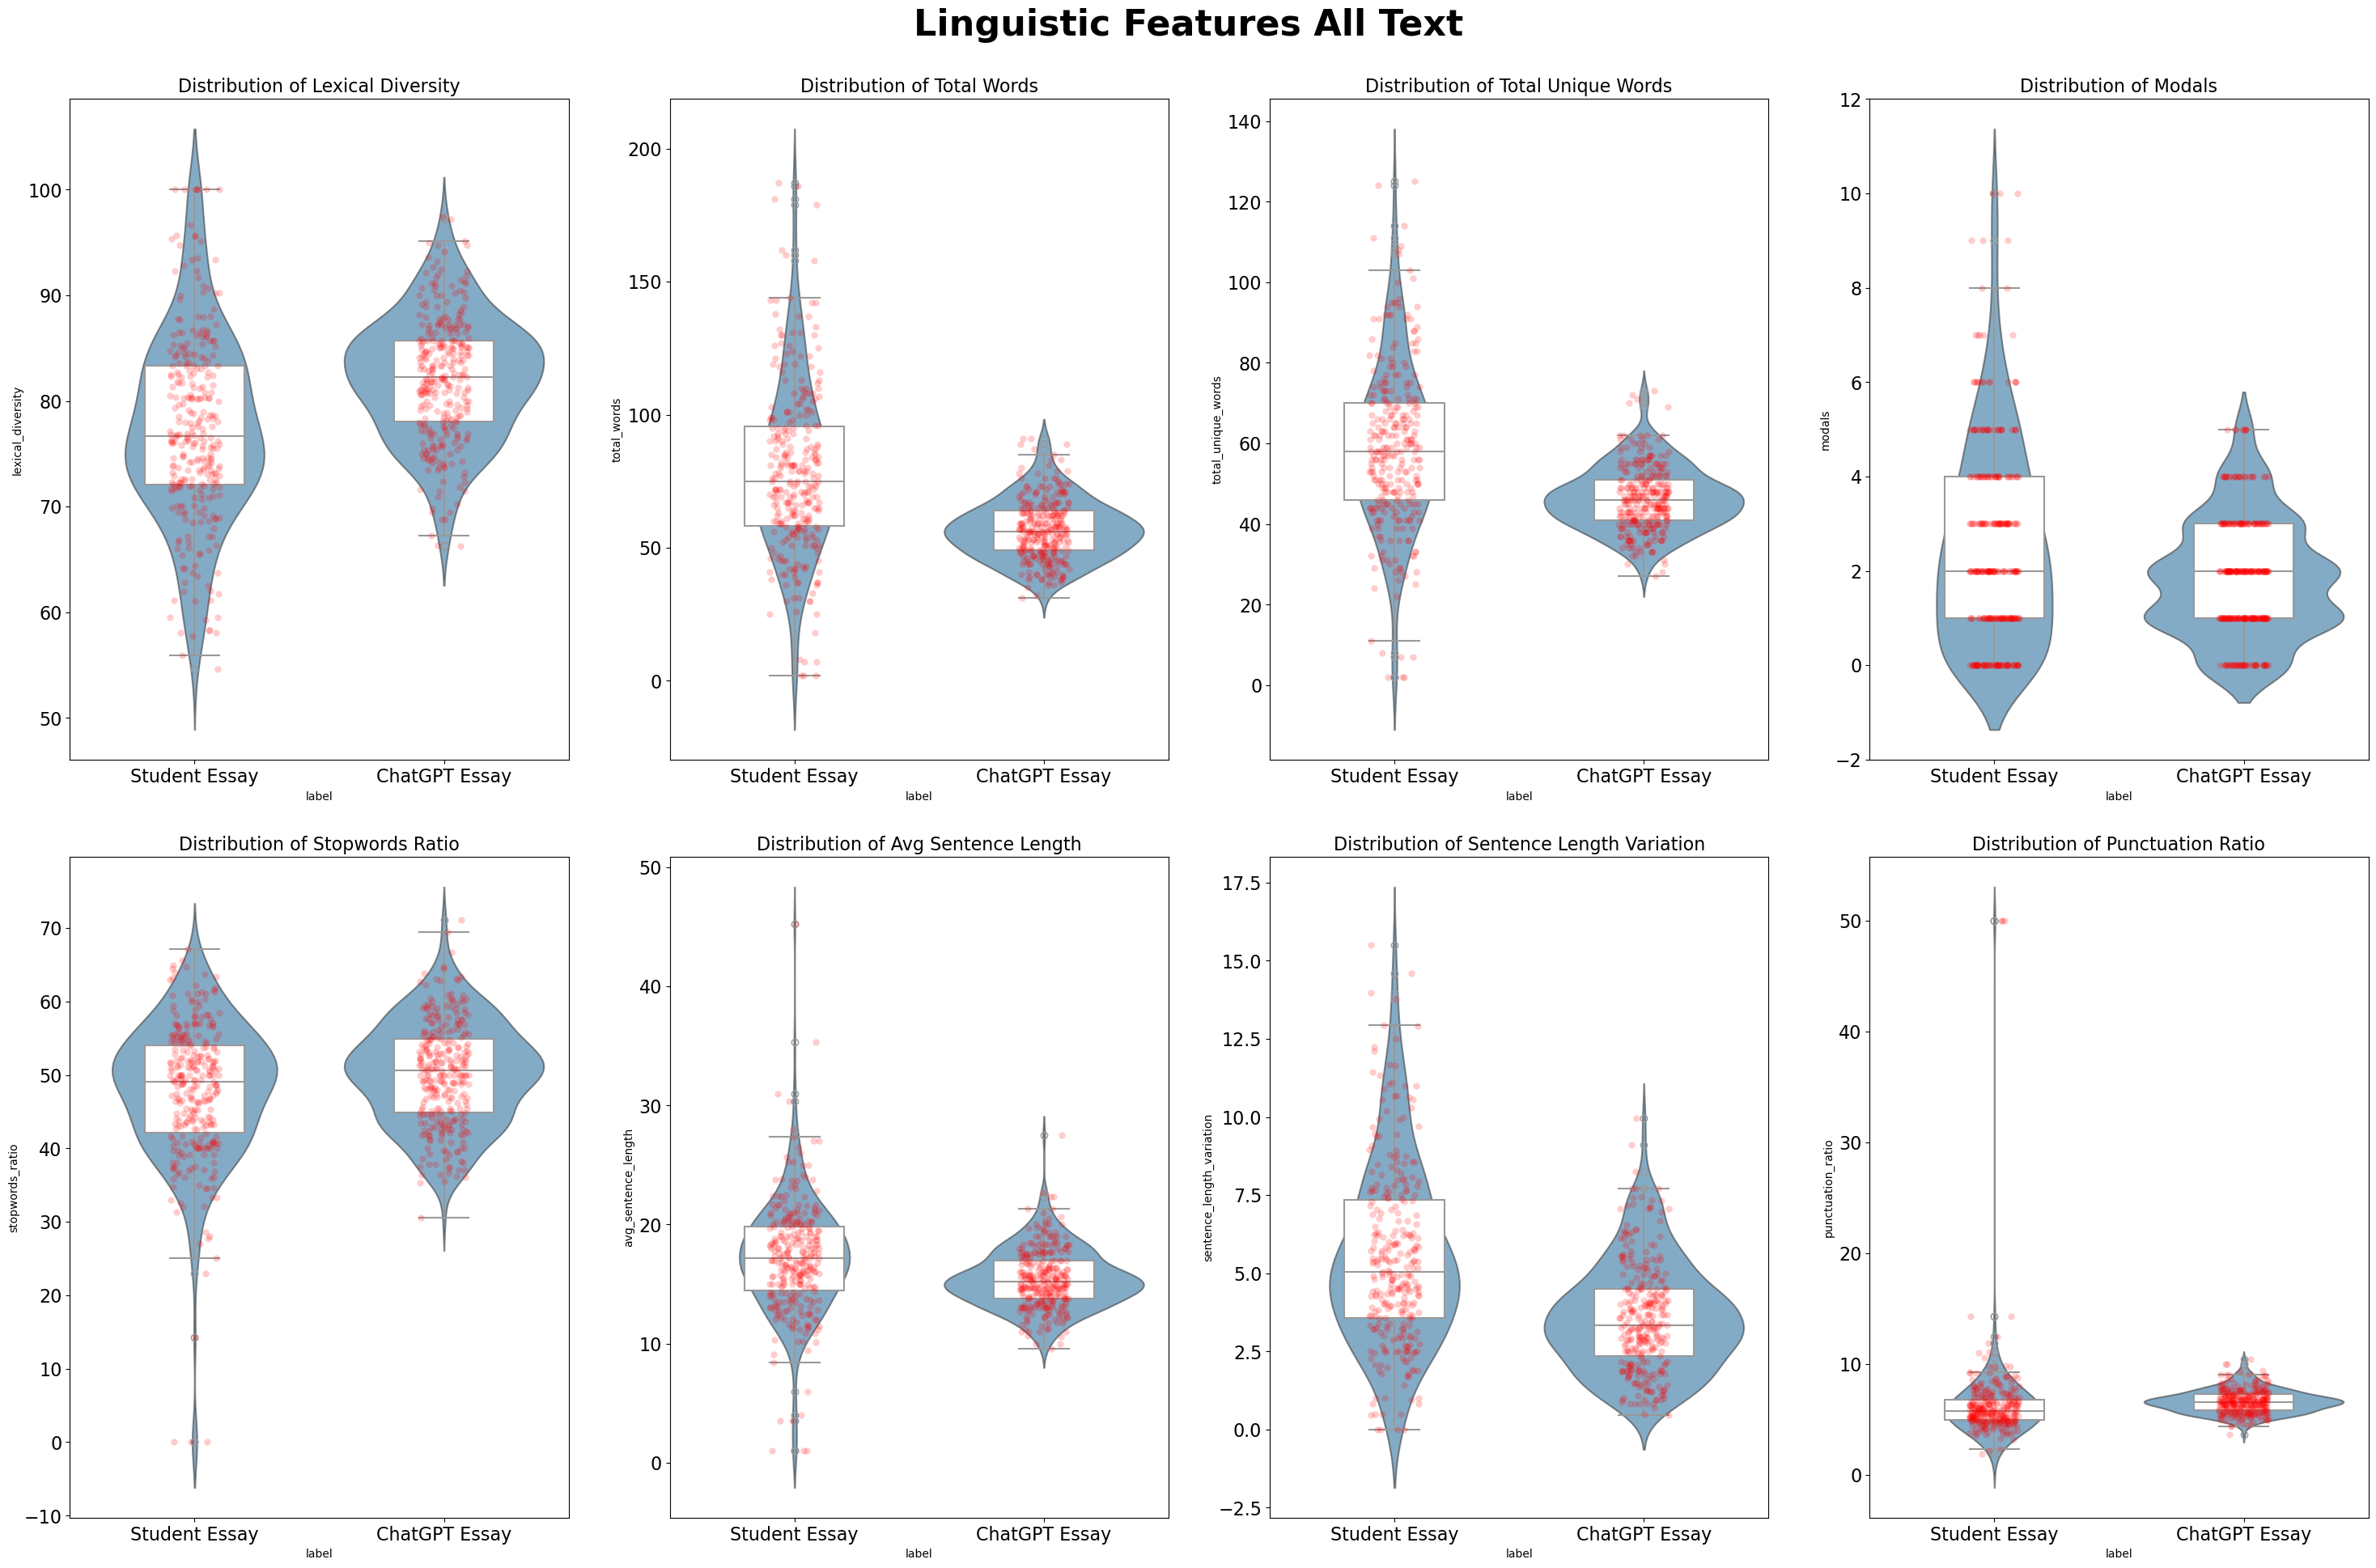

In [38]:
plt.figure(figsize=(30, 20))
for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
    'avg_sentence_length',
    'sentence_length_variation',
    'punctuation_ratio'
]):
    plt.subplot(2, 4, i+1)
    sns.violinplot(x='label', y=feature, data=combined_features, inner=None, alpha=0.6, linewidth=1.5)
    sns.boxplot(x='label', y=feature, data=combined_features, width=0.4, 
                saturation=1, showfliers=True, color='white', linewidth=1.5)
    sns.stripplot(x='label', y=feature, data=combined_features, color='red', alpha=0.2, size=6, jitter=True, dodge=True)
    plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

plt.suptitle('Linguistic Features All Text', fontsize=32, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)

plt.savefig('paper/images/linguistic_features_comparison(all).png', dpi=300, bbox_inches='tight')

plt.show()


# Feature Extraction (Training, Validation, & Test Sets)

In [39]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student (training set)...")
std_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (training set)...")
gpt_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (validation set)...")
std_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (validation set)...")
gpt_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (test set)...")
std_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (test set)...")
gpt_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 1]['text'].tolist()]

# convert
std_tr_features_df = pd.DataFrame(std_tr_features)
gpt_tr_features_df = pd.DataFrame(gpt_tr_features)

std_va_features_df = pd.DataFrame(std_va_features)
gpt_va_features_df = pd.DataFrame(gpt_va_features)

std_te_features_df = pd.DataFrame(std_te_features)
gpt_te_features_df = pd.DataFrame(gpt_te_features)

#Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features (Test Set):")
display(std_te_features_df.head())

print("\nChatGPT Linguistic Features (Test Set):")
display(gpt_te_features_df.head())

Features extraction for Student (training set)...
Features extraction for ChatGPT (training set)...
Features extraction for Student (validation set)...
Features extraction for ChatGPT (validation set)...
Features extraction for Student (test set)...
Features extraction for ChatGPT (test set)...

Student Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,78.571429,42,33,0,50.000000,21.000000,1.000000,4.761905
1,71.590909,88,63,3,56.818182,17.600000,2.727636,5.681818
2,70.967742,62,44,3,40.322581,15.500000,2.692582,6.451613
3,64.084507,142,91,5,50.000000,15.777778,5.328702,6.338028
4,84.905660,53,45,3,56.603774,26.500000,15.500000,3.773585



ChatGPT Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,85.714286,56,48,0,58.928571,18.666667,1.247219,5.357143
1,80.000000,55,44,3,60.000000,27.500000,0.500000,3.636364
2,80.645161,62,50,2,50.000000,20.666667,4.642796,4.838710
3,90.322581,62,56,1,37.096774,15.500000,4.924429,6.451613
4,84.313725,51,43,0,45.098039,17.000000,0.816497,5.882353


In [40]:
std_tr_features_df.shape, gpt_tr_features_df.shape, std_va_features_df.shape, gpt_va_features_df.shape, std_te_features_df.shape, gpt_te_features_df.shape

((223, 8), (223, 8), (15, 8), (15, 8), (60, 8), (67, 8))

# Normalize Linguistic Features (Training, Validation, & Test Sets)

In [41]:
# Combine features into a single DataFrame
all_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)
all_va_features = pd.concat([std_va_features_df, gpt_va_features_df], axis=0)
all_te_features = pd.concat([std_te_features_df, gpt_te_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_tr_features = scaler.fit_transform(all_tr_features)
normalized_va_features = scaler.fit_transform(all_va_features)
normalized_te_features = scaler.fit_transform(all_te_features)

# Separate normalized features back into student and ChatGPT
n_student_tr = len(std_tr_features_df)
n_chatgpt_tr = len(gpt_tr_features_df)

n_student_va = len(std_va_features_df)
n_chatgpt_va = len(gpt_va_features_df)

n_student_te = len(std_te_features_df)
n_chatgpt_te = len(gpt_te_features_df)

std_tr_features_norm = normalized_tr_features[:n_student_tr]
gpt_tr_features_norm = normalized_tr_features[n_student_tr:n_student_tr + n_chatgpt_tr]

std_va_features_norm = normalized_va_features[:n_student_va]
gpt_va_features_norm = normalized_va_features[n_student_va:n_student_va + n_chatgpt_va]

std_te_features_norm = normalized_te_features[:n_student_te]
gpt_te_features_norm = normalized_te_features[n_student_te:n_student_te + n_chatgpt_te]

print("Student features after normalization (training):")
print(std_tr_features_norm[:5])

print("ChatGPT features after normalization (training):")
print(gpt_tr_features_norm[:5])

Student features after normalization (training):
[[-0.5347662   2.09384172  2.40770589  1.01503765 -0.30039667 -0.28244406
   1.51518195  0.00771397]
 [-0.43668639  0.62945723  0.7013651  -0.67627041 -2.04776464 -1.09657976
   1.59579485  0.55320645]
 [-0.75157422  0.32116575  0.21383915 -0.67627041  0.25029571 -0.29496923
   0.73336433  0.01433938]
 [ 0.95082999 -0.79639084 -0.70027199 -1.24003977 -0.28994501 -0.17806769
  -1.13932817 -0.04585322]
 [-1.35863666 -0.25688076 -0.63933125 -1.24003977  0.7803048  -1.0464791
  -0.73291949  0.51124549]]
ChatGPT features after normalization (training):
[[ 0.58392064 -0.6422451  -0.5783905   0.4512683   0.44511397 -0.90870229
  -1.38397281  0.40264065]
 [ 1.02254991 -1.02760944 -1.0049757   1.57880701  1.70045861  1.03269821
  -1.21941522 -0.50809882]
 [-0.70259167 -0.5266358  -0.76121273 -0.11250106  0.98043471 -0.72082482
  -0.3610591   0.26880439]
 [ 0.21230277 -0.33395363 -0.27368679 -1.24003977 -0.00899026 -0.40769571
  -0.15821709  0.075

# Visualize Linguistic Features (Data Test)

In [42]:
# Add labels to features
std_tr_features_df['label'] = 'Student Essay'
gpt_tr_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)

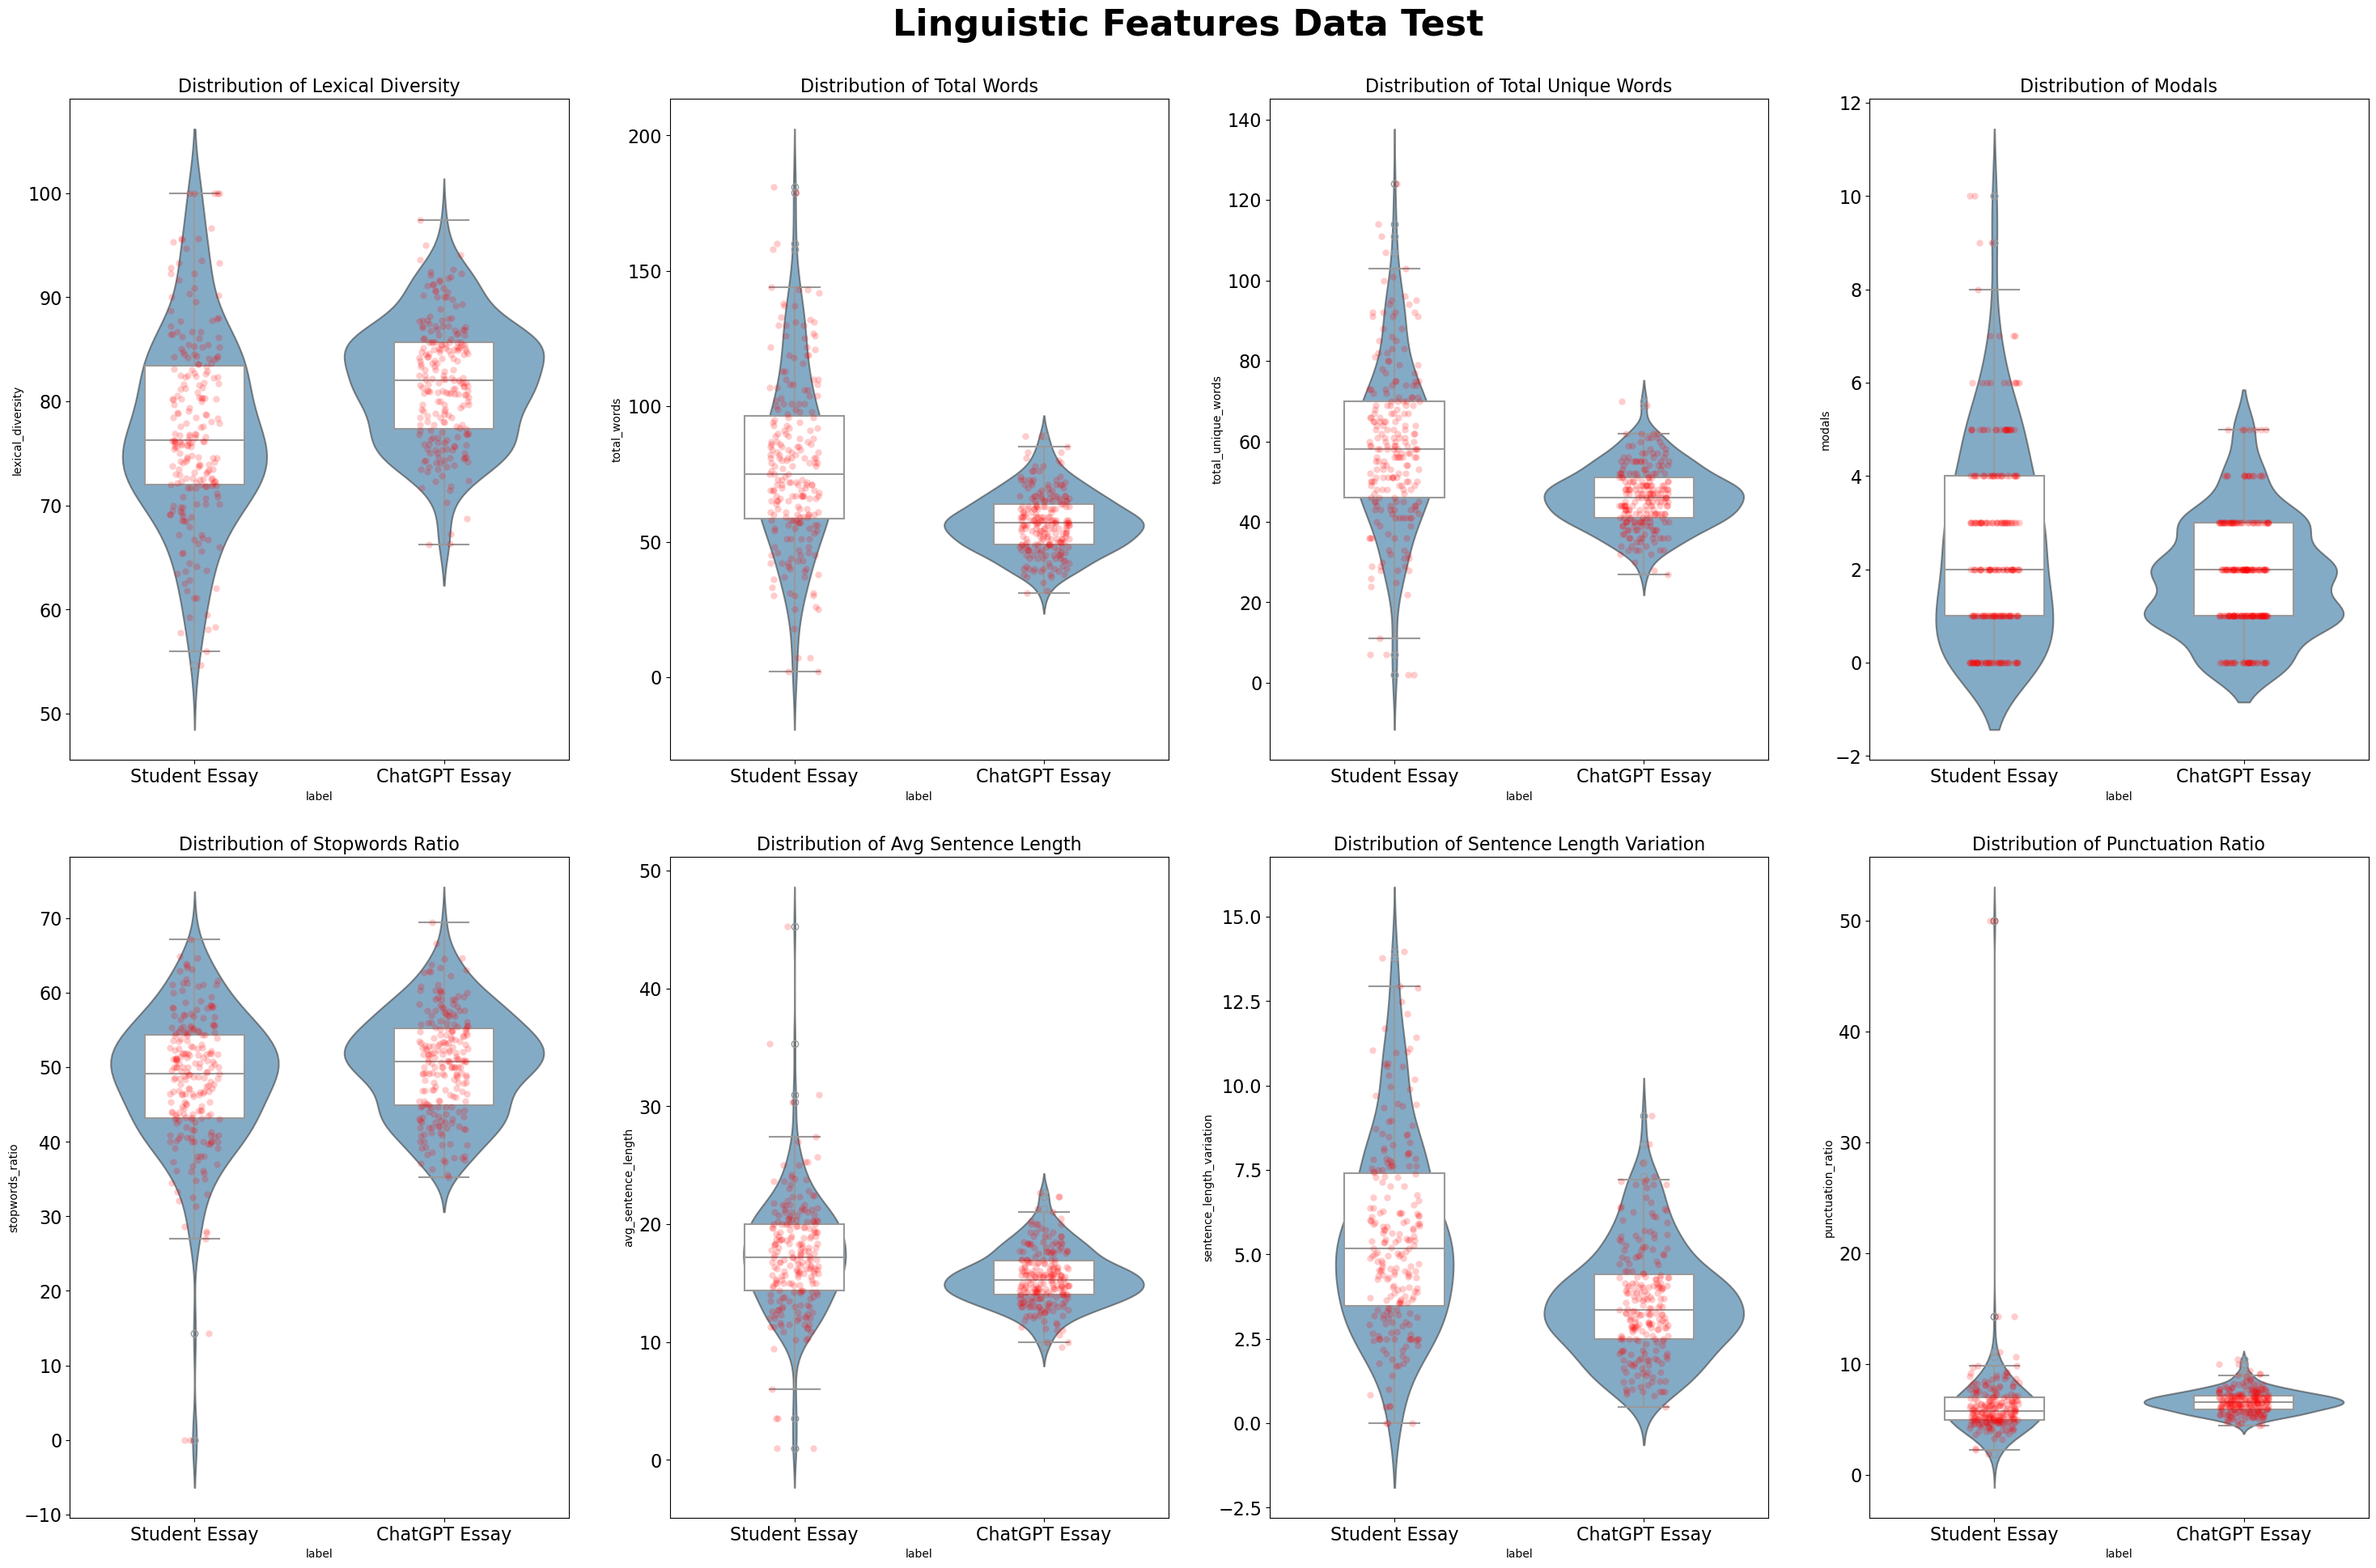

In [43]:
def new_func():
    plt.figure(figsize=(30, 20))
    for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
    'avg_sentence_length',
    'sentence_length_variation',
    'punctuation_ratio'
]):
        plt.subplot(2, 4, i+1)
        sns.violinplot(x='label', y=feature, data=combined_tr_features, inner=None, alpha=0.6, linewidth=1.5)
        sns.boxplot(x='label', y=feature, data=combined_tr_features, width=0.4, 
                saturation=1, showfliers=True, color='white', linewidth=1.5)
        sns.stripplot(x='label', y=feature, data=combined_tr_features, color='red', alpha=0.2, size=6, jitter=True, dodge=True)
        plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

new_func()

plt.suptitle('Linguistic Features Data Test', fontsize=32, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)

plt.savefig('paper/images/linguistic_features_comparison(test).png', dpi=300, bbox_inches='tight')

plt.show()


In [44]:
# Check dimensions of your embedding arrays
print("std_te_emb shape:", std_te_emb.shape)
print("gpt_te_emb shape:", gpt_te_emb.shape)


# Print shapes of the resulting similarity scores
print("std_std_te_sim_scores shape:", np.array(std_std_te_sim_scores).shape)
print("std_gpt_te_sim_scores shape:", np.array(std_gpt_te_sim_scores).shape)
print("gpt_std_te_sim_scores shape:", np.array(gpt_std_te_sim_scores).shape)
print("gpt_gpt_te_sim_scores shape:", np.array(gpt_gpt_te_sim_scores).shape)

# Check shapes of the combined arrays
print("std_te_sim_scores shape:", std_te_sim_scores.shape)
print("gpt_te_sim_scores shape:", gpt_te_sim_scores.shape)

print("std_te_features_norm shape:", std_te_features_norm.shape)
print("gpt_te_features_norm shape:", gpt_te_features_norm.shape)

std_te_emb shape: (60, 256)
gpt_te_emb shape: (67, 256)
std_std_te_sim_scores shape: (60,)
std_gpt_te_sim_scores shape: (60,)
gpt_std_te_sim_scores shape: (67,)
gpt_gpt_te_sim_scores shape: (67,)
std_te_sim_scores shape: (2, 60)
gpt_te_sim_scores shape: (2, 67)
std_te_features_norm shape: (60, 8)
gpt_te_features_norm shape: (67, 8)


# Data Preparation for Classification

In [45]:
# Combine embeddings for model 1 (already correct)
emb_tr_features = np.vstack([std_tr_emb, gpt_tr_emb])
emb_va_features = np.vstack([std_va_emb, gpt_va_emb])
emb_te_features = np.vstack([std_te_emb, gpt_te_emb])

std_tr_features_selected = std_tr_features_norm
gpt_tr_features_selected = gpt_tr_features_norm

std_va_features_selected = std_va_features_norm
gpt_va_features_selected = gpt_va_features_norm

std_te_features_selected = std_te_features_norm
gpt_te_features_selected = gpt_te_features_norm

linguistic_tr_features = np.vstack([
    std_tr_features_selected,
    gpt_tr_features_selected
])
linguistic_va_features = np.vstack([
    std_va_features_selected,
    gpt_va_features_selected
])
linguistic_te_features = np.vstack([
    std_te_features_selected,
    gpt_te_features_selected
])

std_tr_sim_scores_transposed = std_tr_sim_scores.T 
gpt_tr_sim_scores_transposed = gpt_tr_sim_scores.T
similarity_tr_scores = np.vstack([
    std_tr_sim_scores_transposed,
    gpt_tr_sim_scores_transposed,
])

std_va_sim_scores_transposed = std_va_sim_scores.T 
gpt_va_sim_scores_transposed = gpt_va_sim_scores.T
similarity_va_scores = np.vstack([
    std_va_sim_scores_transposed,
    gpt_va_sim_scores_transposed,
])
std_te_sim_scores_transposed = std_te_sim_scores.T 
gpt_te_sim_scores_transposed = gpt_te_sim_scores.T
similarity_te_scores = np.vstack([
    std_te_sim_scores_transposed,
    gpt_te_sim_scores_transposed,
])

# Create labels
std_tr_labels = np.zeros(len(train_set[train_set['label'] == 0]))
gpt_tr_labels = np.ones(len(train_set[train_set['label'] == 1]))
tr_labels = np.hstack([std_tr_labels, gpt_tr_labels])

# Validation set labels
std_va_labels = np.zeros(len(val_set[val_set['label'] == 0]))
gpt_va_labels = np.ones(len(val_set[val_set['label'] == 1]))
va_labels = np.hstack([std_va_labels, gpt_va_labels])

# Test set labels
std_te_labels = np.zeros(len(test_set[test_set['label'] == 0]))
gpt_te_labels = np.ones(len(test_set[test_set['label'] == 1]))
te_labels = np.hstack([std_te_labels, gpt_te_labels])

tr_labels = tr_labels.astype(int)
va_labels = va_labels.astype(int)
te_labels = te_labels.astype(int)

# Verify shapes
print(f"emb_te_features shape: {emb_te_features.shape}")
print(f"linguistic_te_features shape: {linguistic_te_features.shape}")
print(f"similarity_te_scores shape: {similarity_te_scores.shape}")
print(f"te_labels shape: {te_labels.shape}")

print(f"emb_te_features value: {emb_te_features[:5]}")
print(f"linguistic_te_features value: {linguistic_te_features[:5]}")
print(f"similarity_te_scores value: {similarity_te_scores[:5]}")
print(f"te_labels value: {te_labels[:5]}")


emb_te_features shape: (127, 256)
linguistic_te_features shape: (127, 8)
similarity_te_scores shape: (127, 2)
te_labels shape: (127,)
emb_te_features value: [[ 0.05638609  0.10181724 -0.01838484 ... -0.04067063 -0.00953746
  -0.06239055]
 [ 0.0798977  -0.05357189 -0.0295577  ... -0.06761629 -0.00179519
   0.06680878]
 [ 0.06353217  0.0080902  -0.00641217 ... -0.08738284  0.0316228
   0.03681792]
 [ 0.08828989 -0.01692248 -0.01315711 ... -0.1065533   0.02012042
   0.0372228 ]
 [ 0.0895128  -0.0058612  -0.06725173 ... -0.12087309  0.04657162
   0.01519189]]
linguistic_te_features value: [[-0.19681855 -0.93835995 -1.13891731 -1.14945585  0.26658986  1.27550234
  -1.31808996 -0.48102161]
 [-1.09544636  0.7128144   0.55942905  0.45472979  1.0108656   0.37206798
  -0.68579476 -0.25738739]
 [-1.17566895 -0.22045806 -0.51619031  0.45472979 -0.78980152 -0.1859356
  -0.6986241  -0.07024757]
 [-2.06177296  2.65114951  2.14455233  1.52418688  0.26658986 -0.1121256
   0.26616549 -0.09786042]
 [ 0.6

# Build Classification Model

In [46]:
emb_input = tf.keras.layers.Input(
    shape=(256,),
    dtype=tf.float32, 
    name="embeddings"
)

sim_score_input = tf.keras.layers.Input(
    shape=(2,), 
    dtype=tf.float32, 
    name="similarity_score"
)

linguistic_input = tf.keras.layers.Input(
    shape=(8,),
    dtype=tf.float32, 
    name="linguistic_features"
)

emb_dense = tf.keras.layers.Dense(128, activation="relu")(emb_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(sim_score_input)
lin_dense = tf.keras.layers.Dense(64, activation="relu")(linguistic_input)

combined = tf.keras.layers.Concatenate()([emb_dense, sim_dense, lin_dense])

x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

classifier = tf.keras.Model(
    inputs=[emb_input, sim_score_input, linguistic_input],
    outputs=output,
    name="text_classifier"
)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embeddings (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 similarity_score (InputLay  [(None, 2)]                  0         []                            
 er)                                                                                              
                                                                                                  
 linguistic_features (Input  [(None, 8)]                  0         []                            
 Layer)                                                                                           
                                                                                    

# Create Data Input for Classification

In [47]:
train_inputs = {
    "embeddings": emb_tr_features,
    "similarity_score": similarity_tr_scores,
    "linguistic_features": linguistic_tr_features
}

val_inputs = {
    "embeddings": emb_va_features,
    "similarity_score": similarity_va_scores,
    "linguistic_features": linguistic_va_features
}


test_inputs = {
    "embeddings": emb_te_features,
    "similarity_score": similarity_te_scores,
    "linguistic_features": linguistic_te_features
}

train_labels = tr_labels
val_labels = va_labels
test_labels = te_labels

# Train Classification Model

Training Classification Model...
Epoch 1/30
28/28 [==============================] - 2s 16ms/step - loss: 0.6681 - accuracy: 0.6794 - precision: 0.6887 - recall: 0.6547 - auc: 0.7372 - val_loss: 0.6156 - val_accuracy: 0.8667 - val_precision: 0.8667 - val_recall: 0.8667 - val_auc: 0.9578
Epoch 2/30
28/28 [==============================] - 0s 8ms/step - loss: 0.5731 - accuracy: 0.9596 - precision: 0.9325 - recall: 0.9910 - auc: 0.9962 - val_loss: 0.5246 - val_accuracy: 0.9000 - val_precision: 0.8750 - val_recall: 0.9333 - val_auc: 0.9822
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 0.4577 - accuracy: 0.9865 - precision: 0.9780 - recall: 0.9955 - auc: 0.9963 - val_loss: 0.4192 - val_accuracy: 0.9333 - val_precision: 0.8824 - val_recall: 1.0000 - val_auc: 0.9867
Epoch 4/30
28/28 [==============================] - 0s 7ms/step - loss: 0.3220 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.3122 - val_accuracy: 0.9333 - val_precisi

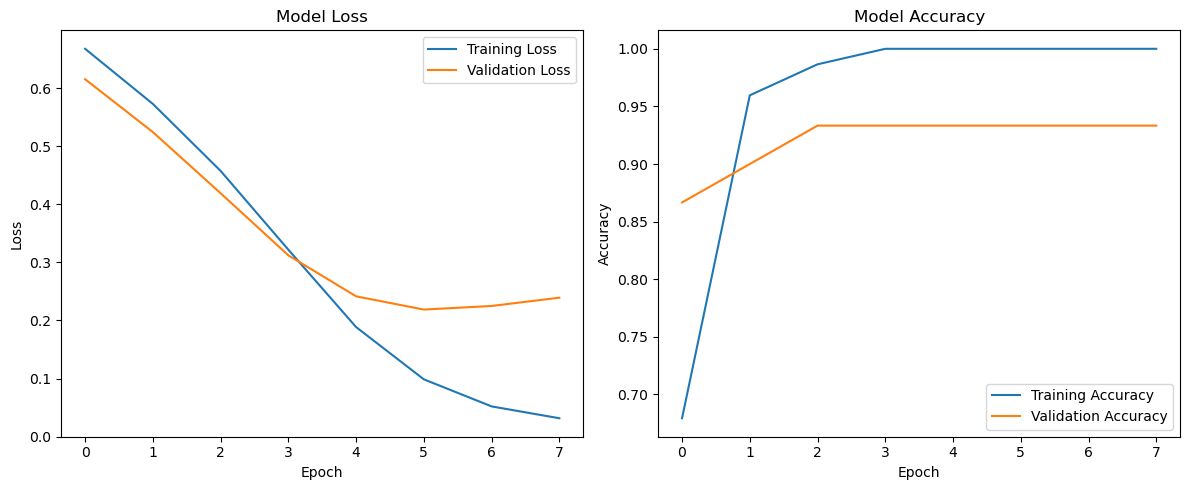

In [48]:
# Training classifier
print("Training Classification Model...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=30,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation Model

Making predictions on training and validation data...
15/15 [==============================] - 0s 2ms/step
Generating ROC curve...


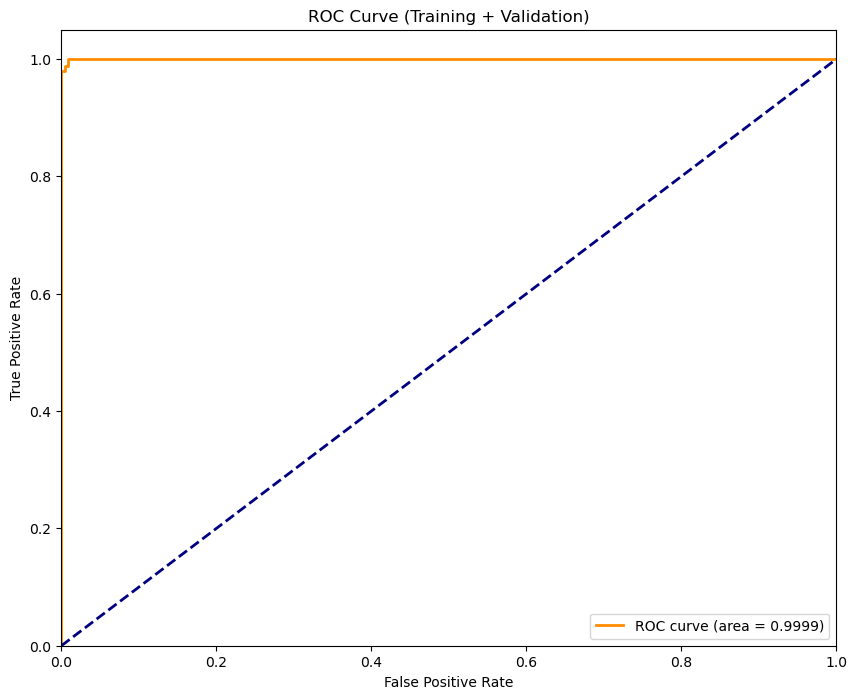

Analyzing threshold performance...


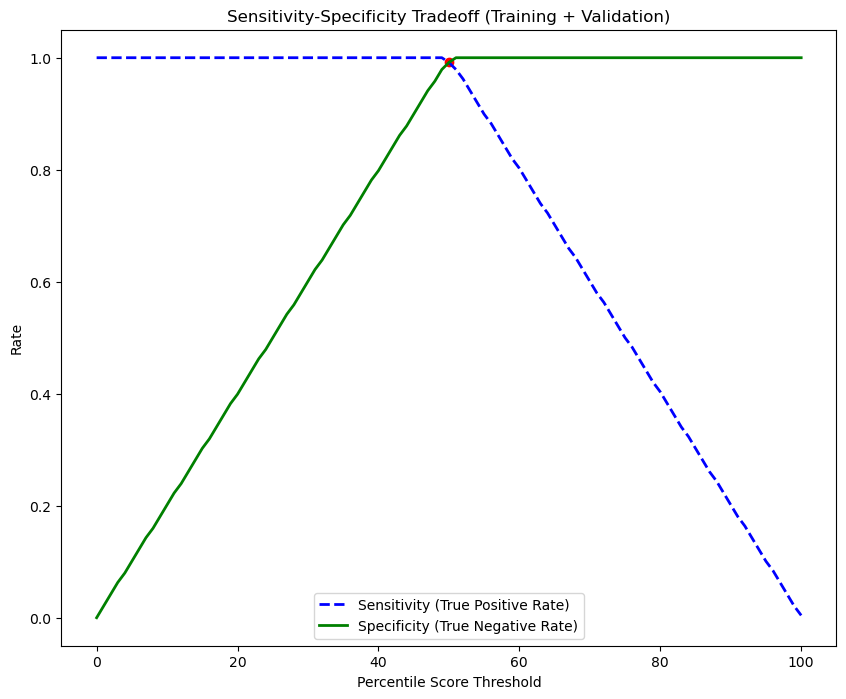

Threshold points with equal sensitivity and specificity:
Percentile: 50.0, Threshold: 0.8604, Rate: 0.9916
Selected optimal threshold: 0.8604


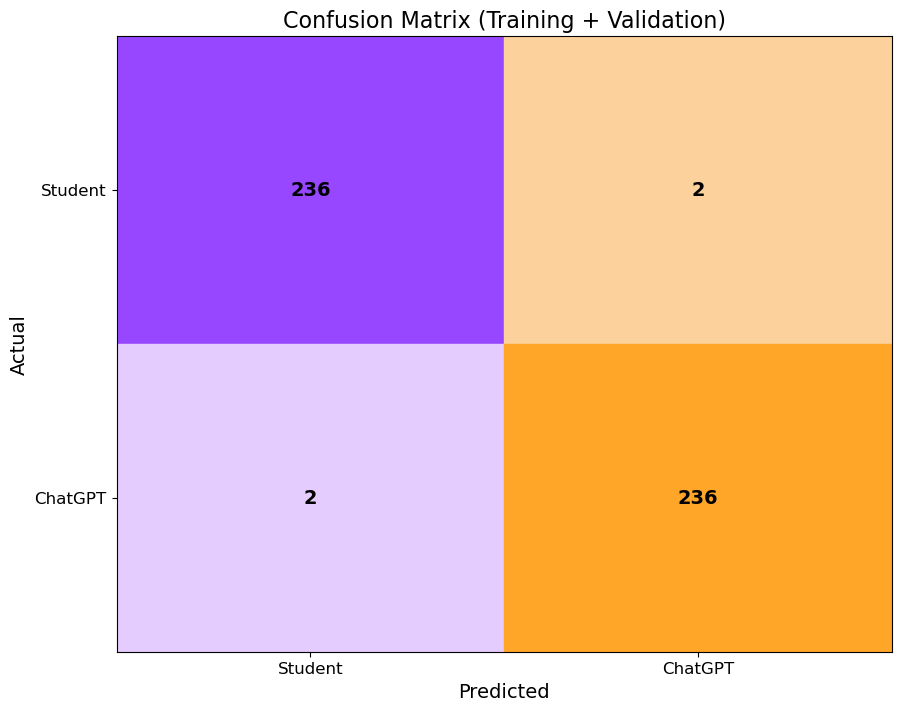


Detailed Classification Report (Training + Validation):
              precision    recall  f1-score   support

     Student       0.99      0.99      0.99       238
     ChatGPT       0.99      0.99      0.99       238

    accuracy                           0.99       476
   macro avg       0.99      0.99      0.99       476
weighted avg       0.99      0.99      0.99       476



In [49]:
# Combine only training and validation inputs and labels (excluding test data)
combined_inputs = {
    "embeddings": np.concatenate([train_inputs["embeddings"], val_inputs["embeddings"]]),
    "similarity_score": np.concatenate([train_inputs["similarity_score"], val_inputs["similarity_score"]]),
    "linguistic_features": np.concatenate([train_inputs["linguistic_features"], val_inputs["linguistic_features"]])
}
combined_labels = np.concatenate([train_labels, val_labels])

# Make predictions on combined training and validation data
print("Making predictions on training and validation data...")
combined_predictions = classifier.predict(combined_inputs)

# Calculate ROC curve and plot
print("Generating ROC curve...")
fpr, tpr, _ = roc_curve(combined_labels, combined_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Training + Validation)')
plt.legend(loc="lower right")
plt.savefig('paper/images/roc_curve (train_val).png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate performance at different thresholds
print("Analyzing threshold performance...")
percentiles = np.linspace(0, 100, num=101)
sensitivity_data = []  
specificity_data = [] 
intersection_points = []

for p in percentiles:
    threshold = np.percentile(combined_predictions, p)
    predictions_binary = (combined_predictions >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(combined_labels, predictions_binary).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity_data.append(sensitivity)
    specificity_data.append(specificity)
    
    # Identify where sensitivity and specificity are approximately equal
    if np.isclose(sensitivity, specificity, atol=1e-2):
        intersection_points.append((p, threshold, sensitivity))

# Plot sensitivity-specificity tradeoff
plt.figure(figsize=(10, 8))
plt.plot(percentiles, sensitivity_data, label='Sensitivity (True Positive Rate)', color='blue', lw=2, linestyle='--')
plt.plot(percentiles, specificity_data, label='Specificity (True Negative Rate)', color='green', lw=2)

# Highlight balanced points
for p, threshold, rate in intersection_points:
    plt.scatter(p, rate, color='red')

plt.xlabel('Percentile Score Threshold')
plt.ylabel('Rate')
plt.title('Sensitivity-Specificity Tradeoff (Training + Validation)')
plt.legend(loc="best")
plt.savefig('paper/images/tradeoff_with_intersections (train_val).png', dpi=300, bbox_inches='tight')
plt.show()

print("Threshold points with equal sensitivity and specificity:")
for p, threshold, rate in intersection_points:
    print(f"Percentile: {p:.1f}, Threshold: {threshold:.4f}, Rate: {rate:.4f}")

if intersection_points:
    _, optimal_threshold, _ = intersection_points[0]
else:
    optimal_threshold = np.percentile(combined_predictions, 50)

print(f"Selected optimal threshold: {optimal_threshold:.4f}")

# Apply optimal threshold for final predictions
combined_predictions_binary = (combined_predictions >= optimal_threshold).astype(int)

# Generate confusion matrix with custom styling
cm_combined = confusion_matrix(combined_labels, combined_predictions_binary)

# Define custom colors for confusion matrix
colors = np.array([
    ["#9747FF", "#FCD19C"],  
    ["#E4CCFF", "#FFA629"]
])

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
rows, cols = cm_combined.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_combined[i, j]), ha='center', va='center', 
                 color='black', fontsize=14, fontweight='bold')

plt.title('Confusion Matrix (Training + Validation)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig('paper/images/confusion_matrix(train_val).png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nDetailed Classification Report (Training + Validation):")
print(classification_report(combined_labels, combined_predictions_binary, target_names=['Student', 'ChatGPT']))

Making predictions on test dataset...
4/4 [==============================] - 0s 2ms/step


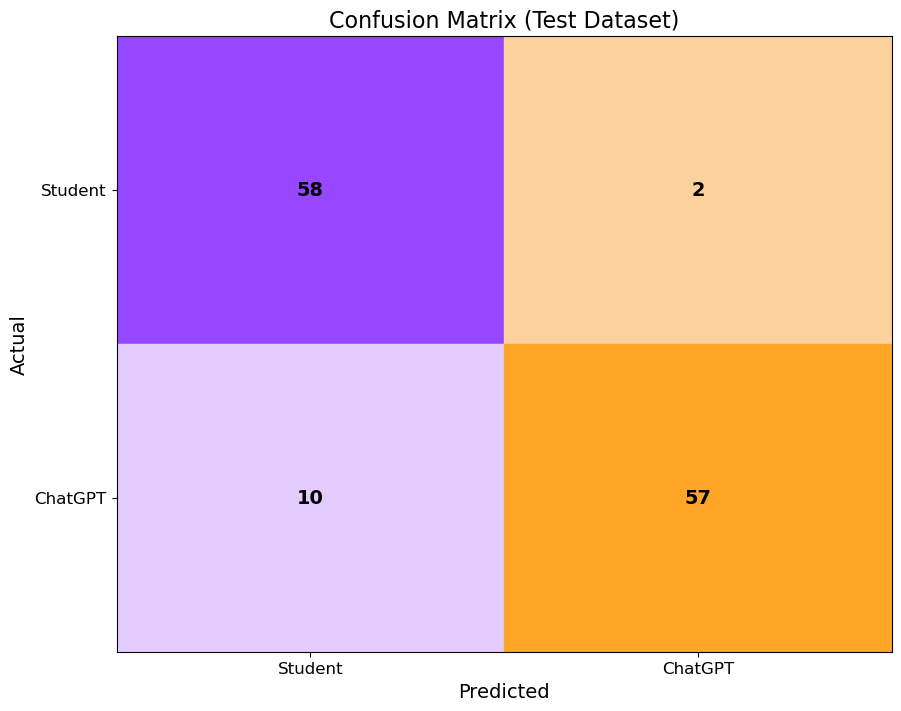


Detailed Classification Report (test set):
              precision    recall  f1-score   support

     Student       0.85      0.97      0.91        60
     ChatGPT       0.97      0.85      0.90        67

    accuracy                           0.91       127
   macro avg       0.91      0.91      0.91       127
weighted avg       0.91      0.91      0.91       127



In [50]:
# Make predictions on test data only
print("Making predictions on test dataset...")
test_predictions = classifier.predict(test_inputs)

test_predictions_binary = (test_predictions >= optimal_threshold).astype(int)

cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Define custom colors for confusion matrix
colors = np.array([
    ["#9747FF", "#FCD19C"],  
    ["#E4CCFF", "#FFA629"]
])

# Visualize confusion matrix for test data
plt.figure(figsize=(10, 8))
rows, cols = cm_test.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_test[i, j]), ha='center', va='center', 
                 color='black', fontsize=14, fontweight='bold')

plt.title('Confusion Matrix (Test Dataset)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.savefig('paper/images/confusion_matrix (test set).png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report for test data
print("\nDetailed Classification Report (test set):")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))

# Misclassified Essay Report

In [51]:
misclassified_students = []
misclassified_chatgpt = []
test_actual_texts = test_set['text'].values
test_names = test_set['name'].values
similarity_scores = test_inputs['similarity_score']

for i, (actual, pred) in enumerate(zip(test_labels, test_predictions_binary)):
    if actual == 0 and pred == 1:
        student_idx = i
        most_similar_chatgpt = None
        highest_similarity = -1
        avg_similarity_to_chatgpt = similarity_scores[i][1]
        for j, gpt_text in enumerate(gpt_txt):
            if j < len(gpt_te_emb):
                student_embedding = tf.expand_dims(std_te_emb[student_idx], 0) if student_idx < len(std_te_emb) else None
                chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
                
                if student_embedding is not None:
                    similarity = cos_sim(student_embedding, chatgpt_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_chatgpt = gpt_txt[j]
        
        misclassified_students.append({
            'Type': 'False Positive',
            'Name': test_names[i],
            'Text': test_actual_texts[i], 
            'Model Confidence': test_predictions[i][0],
            'Avg. Similarity': avg_similarity_to_chatgpt,
            'Most Similar Text': most_similar_chatgpt,
            'Similarity Score': highest_similarity
        })
    elif actual == 1 and pred == 0:
        chatgpt_idx = i
        most_similar_student = None
        highest_similarity = -1
        avg_similarity_to_student = similarity_scores[i][0]
        for j, std_text in enumerate(std_txt):
            if j < len(std_te_emb):
                chatgpt_embedding = tf.expand_dims(gpt_te_emb[chatgpt_idx-len(std_te_emb)], 0) if chatgpt_idx >= len(std_te_emb) else None
                student_embedding = tf.expand_dims(std_te_emb[j], 0)
                
                if chatgpt_embedding is not None:
                    similarity = cos_sim(chatgpt_embedding, student_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_student = std_txt[j]
        
        misclassified_chatgpt.append({
            'Type': 'False Negative', 
            'Name': test_names[i],
            'Text': test_actual_texts[i], 
            'Model Confidence': 1 - test_predictions[i][0],
            'Avg. Similarity': avg_similarity_to_student,
            'Most Similar Text': most_similar_student,
            'Similarity Score': highest_similarity
        })

sorted_misclassified_students = sorted(
    misclassified_students, 
    key=lambda x: (x['Similarity Score'], x['Avg. Similarity'], x['Model Confidence']),
    reverse=True
)

sorted_misclassified_chatgpt = sorted(
    misclassified_chatgpt, 
    key=lambda x: (x['Similarity Score'], x['Avg. Similarity'], x['Model Confidence']),
    reverse=True
)

print("Top 3 Student Essays Misclassified as ChatGPT (by Similarity):")
display(pd.DataFrame(sorted_misclassified_students).head(3))

print("\nTop 2 ChatGPT Essays Misclassified as Student (by Similarity):")
display(pd.DataFrame(sorted_misclassified_chatgpt).head(2))

Top 3 Student Essays Misclassified as ChatGPT (by Similarity):


,Type,Name,Text,Model Confidence,Avg. Similarity,Most Similar Text,Similarity Score
0,False Positive,Sy********* Mu****** Wa***,"di era digital dan globalisasi, usaha menjadi sangat penting. teknologi memudahkan kita belajar dan berkembang tanpa batas geografis, tetapi juga meningkatkan persaingan. karena itu, usaha yang konsisten dan kerja keras diperlukan untuk memanfaatkan peluang digital dan mencapai keberhasilan. globalisasi turut menuntut tenaga kerja yang kompeten dan adaptif, sehingga peningkatan kualitas diri melalui pendidikan, keterampilan digital, dan kerja keras menjadi kunci sukses menghadapi tantangan global.",0.930394,0.830989,"dalam upaya mewujudkan kejayaan dalam masyarakat multikultural, seluruh elemen bangsa harus berkomitmen untuk menjaga persatuan dan kesatuan. komitmen ini harus diwujudkan dalam aksi nyata dan kebijakan yang berkelanjutan. peran aktif seluruh lapisan masyarakat, baik pemerintah, swasta, maupun individu, sangat diperlukan untuk menciptakan tatanan sosial yang damai dan harmonis.",0.933612
1,False Positive,Sy********* Mu****** Wa***,"ada banyak bentuk usaha yang bisa kita lakukan dalam mengolah hidup, salah satunya adalah melalui pendidikan. pendidikan adalah ladang subur yang menghasilkan manfaat berkelanjutan. melalui usaha dalam belajar, kita dapat mengembangkan potensi, meningkatkan keterampilan, dan membuka peluang hidup yang lebih luas.",0.884537,0.548726,"namun, teknologi juga memiliki sisi gelap ketika disalahgunakan. penyebaran hoaks dan ujaran kebencian adalah ancaman nyata yang bisa merusak integritas sosial. karenanya, literasi digital menjadi kebutuhan mendesak agar masyarakat mampu memilah dan memahami informasi dengan kritis.",0.649204



Top 2 ChatGPT Essays Misclassified as Student (by Similarity):


,Type,Name,Text,Model Confidence,Avg. Similarity,Most Similar Text,Similarity Score
0,False Negative,ChatGPT,"setiap orang memulai hidupnya dengan kanvas kosong yang perlahan akan diwarnai oleh berbagai peristiwa dan pengalaman. warna-warna yang kita pilih, pola dan bentuk yang tercipta, semuanya adalah manifestasi dari pilihan dan tindakan kita. ada kalanya kita dihadapkan pada warna-warna suram, mungkin akibat kesedihan atau kegagalan, namun kita punya kuasa untuk memilih, apakah warna suram itu akan menguasai kanvas kita atau kita akan menambahkan warna lain yang lebih cerah? pilihan ini mempengaruhi bagaimana kita menghargai hidup kita sendiri.",0.887501,0.437691,"tidak diragukan lagi bahwa saat ini penggunaan teknologi internet kian masif di kalangan masyarakat. dalam beberapa tahun terakhir, terdapat berbagai perkembangan infrastruktur telekomunikasi di indonesia yakni dengan hadirnya jaringan 4g dan 5g yang kemudian meningkatkan aksesibilitas internet secara nasional. selain itu, akses masyarakat terhadap media elektronik cenderung mudah dan tidak memerlukan prasyarat tertentu. hal ini dapat dilihat dari menjamurnya berbagai toko elektronik seperti toko gawai, laptop, tablet, serta media lainnya.",0.575938
1,False Negative,ChatGPT,"kesadaran lingkungan adalah dimensi lain dalam usaha mengolah hidup. di tengah kerusakan ekologi yang kian nyata, pemuda dituntut untuk bergerak bersama, berpikir kritis dan bertindak nyata ancaman terhadap lingkungan alam. menyadari bahwa merekalah bagian dari alam yang lebih besar adalah awal dari pembentukan kesadaran ekologis. mereka didorong untuk berpartisipasi dalam kegiatan pelestarian alam, seperti penghijauan dan penanganan limbah, sehingga dapat meninggalkan bumi yang lebih baik bagi generasi mendatang. ketika setiap individu menerima tanggung jawab ekologis dan menjadikannya bagian dari hidup, maka kekhawatiran tentang masa depan yang suram berubah menjadi harapan kolektif.",0.857766,0.455621,"“bhinneka tunggal ika,” sebuah frasa yang pertama kali terlintas saat mendengar kata “keberagaman.” frasa tersebut menjadi semboyan bangsa indonesia yang berarti meski berbeda-beda, kita tetap satu. bhinneka tunggal ika menjadi dasar kuat bahwa bangsa indonesia dapat berdiri tegak selama 78 tahun. indonesia bagaikan kanvas putih yang diberikan berbagai warna cat yang menjadikannya sangat beragam, disertai dengan semboyan bhinneka tunggal ika, menjadikannya seperti sebuah lukisan indah.",0.565071


# Save Model

In [52]:
if not os.path.exists('paper'):
    os.makedirs('paper')

semantic_model.save('paper/semantic_model.h5')
classifier.save('paper/classification_model.h5')

tokenizer.save_pretrained('paper/tokenizer')

with open("paper/scaler_linguistic.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and configuration successfully saved!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and configuration successfully saved!


In [53]:
%load_ext watermark
%watermark
%watermark -iv --gpu

Last updated: 2025-05-10T22:17:56.501307+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit

tensorflow  : 2.19.0
numpy       : 1.26.4
seaborn     : 0.13.2
transformers: 4.39.3
matplotlib  : 3.9.2
pandas      : 2.2.2
sklearn     : 1.5.1
imblearn    : 0.12.3
re          : 2.2.1

GPU Info: 
  GPU 0: NVIDIA GeForce RTX 4060 Ti

